# Simulation functions

In [1]:
import os
import sys
import seaborn as sns
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BEE import bee
import jax.numpy as jnp

#m = bee(platform='cpu')
m = bee(platform='cpu')
import BEE.NBDA as NBDA
import numpy as np
import igraph as ig
import jax
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
@jax.jit
def scale(x):
    return (x - x.mean()) / x.std() # for 

jax.local_device_count 16


In [2]:
import random as rd
def random_seed():
    return rd.randint(0,100000000)
random_seed()

46538714

## Covariates simulation

In [3]:
def sim_covNV(N, T, alpha, beta, epsilon, print = False):

    id_cov = m.dist.normal(0.20, 0.5, sample = True, shape=(N,), seed = random_seed())
    cov_NV = m.dist.normal(alpha+ beta*id_cov,epsilon,sample = True, shape = (T,), seed = random_seed())
    if print: 
        colors = cm.viridis(np.linspace(0, 1, N))  # N distinct colors
        plt.figure(figsize=(12, 6))
        for i in range(cov_NV.shape[0]):
            plt.scatter(np.arange(T), cov_NV[:, i],)

        plt.xlabel("Time")
        plt.ylabel("cov_NV")
        plt.title("cov_NV values over time per individual (colored by row)")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
        plt.tight_layout()
        plt.show()
    return cov_NV.T # rows =individuals, cols = time

In [4]:
def sim_covDF(N, alpha = 0.1, beta = 0.25, epsilon = 0.03):

    id_cov = m.dist.normal(0.20, 0.5, sample = True, shape=(N,), seed = random_seed())
    cov_NV = m.dist.normal(alpha+ beta*id_cov,epsilon,sample = True, shape = (N,), seed = random_seed())
    cov_NV = cov_NV.at[jnp.diag_indices(N)].set(0)
    return cov_NV # rows =individuals, cols = time
#sim_covDF(N = 10)

In [5]:
def grp_belonging_to_mat(block):
    blockMatrix = (block[:, None] == block[None, :]).astype(jnp.int32)
    blockMatrix = blockMatrix.at[jnp.diag_indices(blockMatrix.shape[0])].set(0)
    return blockMatrix
#grp_belonging_to_mat(block1)

In [6]:
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
import numpy as np
jnp.set_printoptions(precision=2,linewidth=200)

def symmetrize(array):
    return (array + array.T) / 2
    
def sim_grp_equal_prob(G, N):
    # Create a 1D array of ones with length G
    ones = jnp.ones((G,))

    # Normalize to get equal probabilities
    equal_probs = ones / G

    # Generate multinomial probabilities
    grp_prob = m.dist.multinomialprobs(equal_probs, 1, sample=True, shape=(N,))

    # Use vmap with jnp.argmax to sample indices
    return vmap(jnp.argmax)(grp_prob)

def sim_grp(N, Ngrp=2,gByGrp=jnp.array([1,3])):
    return [sim_grp_equal_prob(gByGrp[i],N) for i in range(len(gByGrp))]

def create_random_network(n, rate = 0.2, seed=0):
    """
    Create a random network adjacency matrix using the Erdős-Rényi model.
    
    Parameters:
        n (int): Number of nodes in the network.
        rate (float): ate parameter (mean of the distribution), must be >= 0.
        seed (int): Random seed for reproducibility.
        
    Returns:
        jax.numpy.ndarray: Adjacency matrix of the generated random network.
    """
    # Set the random seed for reproducibility
    key = jax.random.PRNGKey(seed)
    
    upper_tri = jax.random.poisson(key,lam = rate,  shape = (n, n))
    lower_tri = upper_tri
    
    # Make the matrix symmetric to represent an undirected graph
    m = upper_tri + lower_tri
    m = m.at[jnp.diag_indices(m.shape[0])].set(0)
    return m

def viz_network(network, block1 = None):
    
    # Convert the input data to NumPy arrays
    adj_matrix_np = np.array(network)
    if block1 is not None:
        block1_np = np.array(block1)
    else:
        block1_np = None


    # Create an igraph graph from the adjacency matrix
    G = ig.Graph.Adjacency((adj_matrix_np > 0).tolist())

    # Add weights to the edges if the adjacency matrix contains weights
    G.es['weight'] = adj_matrix_np[adj_matrix_np.nonzero()] / 4

    # Define the layout
    layout = G.layout_kamada_kawai()
    scale_factor = 20
    layout = [tuple(coord * scale_factor for coord in point) for point in layout]

    # Map the color array to specific colors
    def create_color_map(n):
        color_list = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'pink']
        if n > len(color_list):
            raise ValueError(f"Only {len(color_list)} colors available, but got n={n}")

        return {i: color_list[i] for i in range(n)}
    color_map = create_color_map(np.unique(block1_np).size)

    if block1_np is not None:
        node_colors = [color_map[block] for block in block1_np]
    else:
        node_colors = ['gray'] * len(G.vs)

    edge_colors = []
    for edge in G.es:
        # 'edge.source' gives the emitter node index for directed graphs.
        edge_colors.append(node_colors[edge.source])
    #G.es["color"] = edge_colors

    # Plot the graph
    fig, ax = plt.subplots(figsize=(10, 10)) 
    ig.plot(G, layout=layout, 
            vertex_size=10, vertex_color=node_colors, 
            edge_width=G.es['weight'], target=ax,
            #edge_color=G.es["color"],
            edge_arrow_size=4, edge_curved = 0.2)

    # Display the plot
    plt.show()

def create_covariates(N=50, times=00,
b_ij_mean1 = -2, b_ij_sd1 = 0.2, b_ii_mean1 = 0.1, b_ii_sd1 = 0.01,
b_ij_mean = 0.2, b_ij_sd = 0.1, b_ii_mean = 2, b_ii_sd = 0.5,
s_mu= 0.4, s_sd = 0.1, r_mu= 0.1, r_sd= 0.01,
dr_mu = 0.6, dr_sd = 0.1,
Ngrp = 3, print_network = False, add_covNF = True, add_covNV = True):
    # Covariates--------------------------------------
    covNF = scale(m.dist.normal(0,1, sample = True, shape = (1,N), seed = random_seed()))
    covNV = sim_covNV(N, times, 0.25, 0.30, 0.15)
    covDF = sim_covDF(N)
    # Network-----------------------------------------------------------
    ## Block ---------------------------------------
    blocks = sim_grp(N, Ngrp=2,gByGrp=jnp.array([1,Ngrp]))
    block0=blocks[0]
    block1=blocks[1]
    B0 = m.net.block_model(block0,1, b_ij_mean = b_ij_mean1, b_ij_sd = b_ij_sd1, b_ii_mean = b_ii_mean1, b_ii_sd = b_ii_sd1,sample=True)
    B1 = m.net.block_model(block1,Ngrp, b_ij_mean = b_ij_mean, b_ij_sd = b_ij_sd, b_ii_mean = b_ii_mean, b_ii_sd = b_ii_sd,sample=True)
    ### SR shape =  N individuals---------------------------------------
    if add_covNF == True and add_covNV == True:
        focal_individual_predictors = covNF
        focal_individual_predictors = jnp.concat([covNF, jnp.expand_dims(covNV[:,0],0)])
    elif add_covNF == True and add_covNV == False:
        focal_individual_predictors = covNF
    elif add_covNF == False and add_covNV == True:
        focal_individual_predictors = jnp.expand_dims(covNV[:,0],0)
    
    target_individual_predictors=focal_individual_predictors
    sr =  m.net.sender_receiver(focal_individual_predictors,target_individual_predictors,
                                 s_mu= s_mu, s_sd = s_sd, r_mu= r_mu, r_sd= r_sd,
                                 sample=True)
    ## Dyadic shape = N dyads-------------------------------------- 
    dyadic_predictors = m.net.mat_to_edgl(covDF)
    dr = m.net.dyadic_effect(dyadic_predictors=dyadic_predictors,dr_mu = dr_mu, dr_sd = dr_sd, shape=(N,), sample=True)
    
    network=m.net.edgl_to_mat(m.dist.binomial(total_count = jnp.array([10]), logits = B0 + B1 + sr + dr, sample=True ), N)
    network = network/10

    if print_network:
        viz_network(network, block1)

    # Covariates-----------------------------------------------------------
    time = jnp.arange(0,times)
    covF = focal_individual_predictors # Fixed covariate
    jnp.tile(covF[0,:], (times, 1)).T.shape

    # Time-varying covariate

    covDV = create_random_network(N, rate=0.3, seed=10)
    covDV = vmap(lambda x: covDV + x)(time).transpose(1,2,0) # Time-varying dyadic covariate
    covDF = jnp.stack([create_random_network(N, rate=0.8)] * times, axis=2)
    #covDF = jnp.stack([grp_belonging_to_mat(block1)] * times, axis=2)
    return {
        'covF': covNF[0,:],
        'covV': covNV,
        'network': network,
        'covDF': covDF,
        'covDV': covDV,
        'covDF2': grp_belonging_to_mat(block1)
    }

def heatmap(array):
    # Convert to NumPy for Matplotlib
    data_np = jnp.array(array)  # Alternatively, use `data.to_numpy()`

    # Plot heatmap
    plt.imshow(data_np, cmap="viridis", aspect="auto")
    plt.colorbar(label="Value")
    plt.show()


To create covaraites just run ```covariates_data = create_covariates(N=N, times=times)```

## Diffusion simulations


In [7]:
import ipdb
import jax
@jax.jit
def inv_logit2(x):
    """
    Modified inverse logit function scaling between 0 and 1.
    """
    return (m.link.inv_logit(x) - 0.5) * 2


In [8]:
import random as random2

def diffusion(data, alpha_social, alpha_asocial):
    D_social = data.T_social
    D_asocial = data.T_asocial
    informed = jnp.zeros((data.n,  data.t), dtype=int)

    # Asocial learning only at t = 0-----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], alpha_asocial, axes=(-1, 0))
    theta = m.link.inv_logit(R_asocial)

    # Informed update at t = 0-----------------------
    informed = informed.at[:,0].set(m.dist.binomial(total_count=jnp.ones(theta.shape[0], dtype=int), probs = theta, sample=True, seed = random2.randint(0,10000)))

    for t in range(1,data.t):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], alpha_social, axes=(-1, 0))
        phi = m.link.inv_logit(R_social)        
        attention_weigthed_network = phi*data.network[:,:,t,0]
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], informed[:,t-1], axes=(-1, 0)))


        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], alpha_asocial, axes=(-1, 0))
        theta = m.link.inv_logit(R_asocial)

        # Informed update at t!= 0-----------------------
        p = theta + (1-theta)*social_influence_weight

        informed =  informed.at[:,t].set(jnp.where(informed[:, t-1] == 1, 1, m.dist.binomial(total_count=jnp.ones(p.shape[0], dtype=int),probs = p, sample=True, seed = random2.randint(0,10000))))

    return informed

## NBDA Model
This model should adapt to NBDA class stored information.
In order to implement time varying coefficients we need to define a function that takes the $V$ covariates and $T$ time points and returns the coefficients. All coefficents of the model need this structure.

### Model without covariates

In [9]:
def model0(D_asocial, D_social, status, network):
    N = status.shape[0]
    T = status.shape[1]
    lk = jnp.zeros((N,T))

    # Priors for social effect covariates
    soc = m.dist.normal(0, 2, shape = (1,), sample=False, name='alpha_soc')

    # Priors for asocial effect covariates
    asoc = m.dist.normal(0, 2, shape = (1,), sample=False, name='alpha_asoc')

    # Asocial learning -----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], asoc, axes=(-1, 0))    
    theta = m.link.inv_logit(R_asocial)
    lk = lk.at[:,0].set(theta)


    for t in range(1,T):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], soc, axes=(-1, 0))
        phi = m.link.inv_logit(R_social)
        attention_weigthed_network = phi*network[:,:,t,0]
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc, axes=(-1, 0))
        theta = m.link.inv_logit(R_asocial)
        
        # Informed update at t!= 0-----------------------
        lk = lk.at[:,t].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))

    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        #m.binomial(probs=lk, obs=status[:,:,0])
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status[:,:,0])

In [10]:
import jax.numpy as jnp
from jax import lax, jit
import numpyro

def model2(D_asocial, D_social, status, network):
    N = status.shape[0]
    T = status.shape[1]
    lk = jnp.zeros((N,T))

    # Priors for social effect covariates
    soc = m.dist.normal(0, 2.5, shape = (1,), sample=False, name='alpha_soc')

    # Priors for asocial effect covariates
    asoc = m.dist.normal(0, 2.5, shape = (1,), sample=False, name='alpha_asoc')
    
    # Initial timestep (t=0) - Asocial learning
    R_asocial_0 = jnp.tensordot(D_asocial[:,0,:], asoc, axes=(-1, 0))    
    lk = lk.at[:,0].set(m.link.inv_logit(R_asocial_0) )
    
    # Define a function for a single timestep computation
    def timestep_fn(t, lk_acc):
        # Social learning
        R_social = jnp.tensordot(D_social[:,:,t,:], soc, axes=(-1, 0))
        phi = m.link.inv_logit(R_social)  # Using logistic directly if possible
        attention_weigthed_network = phi * network[:,:,t,0]
        social_influence_weight =  inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))
        
        # Asocial learning
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc, axes=(-1, 0))
        theta = m.link.inv_logit(R_asocial)  # Using logistic directly if possible

        # Update lk for timestep t
        lk_new = lk_acc.at[:,t].set(
            jnp.where(
                status[:, t-1][:,0] == 1, 
                jnp.nan, 
                theta + (1-theta)*social_influence_weight[:,0]
                )
            )
        
        return lk_new
    
    # Use lax.fori_loop for better performance than Python loop
    lk = lax.fori_loop(
        1, T,  # Loop from 1 to T-1
        lambda i, lk_acc: timestep_fn(i, lk_acc),
        lk
    )

    
    # Sample with mask
    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status[:,:,0])
    
    return lk

## Plot posterior distribution and simulated data

In [11]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import random as random2
import math

def generate_random_hex_color():
    number = random2.randint(0, 0xFFFFFF)
    return f"#{number:06X}"

def plot_distributions(posteriors , true_values = dict(alpha_asoc=-5, alpha_soc=1), by_param=False):
    parameters = list(posteriors.keys())
    
    if by_param:
        # Calculate number of rows and columns needed
        n_params = 0
        newParam = []
        for a in parameters:
            if posteriors[a].size > 1:
                n_params += 1
                newParam.append(a)

        parameters = newParam
        
        # Limit columns to between 1 and 3
        if n_params <= 1:
            n_cols = 1
        elif n_params <= 3:
            n_cols = n_params
        else:
            n_cols = 3       

            
        # Calculate number of rows based on n_params and n_cols
        n_rows = math.ceil(n_params / n_cols)
        
        # Create a figure with subplots
        if n_params == 1:
            fig, axes = plt.subplots(1, 1, figsize=(15, 10))
            # Convert single axis to array to make indexing consistent
            axes = np.array([axes])
        else:
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
            # Ensure axes is always a 2D array for consistent indexing
            if n_rows == 1:
                axes = axes.reshape(1, -1)
        
        fig.tight_layout()
    else:
        plt.figure(figsize=(10, 6))
    
    legend_handles = []
    
    for param in parameters:
        if by_param:
            # Calculate index for subplot positioning
            idx = parameters.index(param)
            row = idx // n_cols
            col = idx % n_cols
            
            # Access the appropriate subplot
            if n_params == 1:
                ax = axes[0]
            else:
                ax = axes[row, col]
        else:
            ax = plt.gca()

        mean = posteriors[param].mean(axis=0)
        std = posteriors[param].std(axis=0)
        
        if mean.shape == ():
            color = generate_random_hex_color()
            
            # Create a histogram to get the distribution data
            n, bins, patches = plt.hist(posteriors[param], bins=50, density=True, alpha=0.0)
            
            # Add true value offset
            n = n + true_values[param]
            density = n
            
            # Center the distribution
            center_in_density = density.mean()
            density_shifted = density - center_in_density
            
            # Scale the distribution
            scale_factor = 0.3
            density_scaled = density_shifted * scale_factor
            
            # Shift to true value position
            density_final = density_scaled + true_values[param]
            
            # Get bin centers
            bin_centers = (bins[1:] + bins[:-1]) / 2
            
            # Plot the distribution
            if by_param:
                ax.plot(n, bin_centers, color=color)
                ax.errorbar(true_values[param], mean, color=color, yerr=std, fmt='o')
            else:
                ax.plot(density_final, bin_centers, color=color)
                ax.errorbar(true_values[param], mean, color=color, yerr=std, fmt='o')
            
            # Add legend handle
            legend_handle = mlines.Line2D([], [], color=color, marker='o', linestyle='-', label=f"{param}")
            legend_handles.append(legend_handle)
            
            # Add labels and title
            ax.set_xlabel(f" True Value of Parameter {param}")
            ax.set_ylabel(f" Posterior distribution of Parameter {param}")
            ax.set_title(f'Distribution of {param}')
            if by_param:
                # Set individual y-axis limits for each subplot
                y_min = min(posteriors[param][:, a])
                y_max = max(posteriors[param][:, a])
                padding = 0.1 * (y_max - y_min)
                ax.set_ylim(y_min - padding, y_max + padding)           
            
            if not by_param:
                ax.grid(False)
        else:
            color = generate_random_hex_color()
            length = len(mean)
            
            for a in range(length):
                color = generate_random_hex_color()
                
                # Create a histogram to get the distribution data
                n, bins, patches = plt.hist(posteriors[param][:, a], bins=50, density=True, alpha=0.0)
                
                # Add true value offset
                n = n + true_values[param][a]
                density = n
                
                # Center the distribution
                center_in_density = density.mean()
                density_shifted = density - center_in_density
                
                # Scale the distribution
                scale_factor = 0.3
                density_scaled = density_shifted * scale_factor
                
                # Shift to true value position
                density_final = density_scaled + true_values[param][a]
                
                # Get bin centers
                bin_centers = (bins[1:] + bins[:-1]) / 2
                
                # Plot the distribution
                if by_param:
                    ax.plot(n, bin_centers, color=color)
                    ax.errorbar(true_values[param], mean, color=color, yerr=std, fmt='o')
                else:
                    ax.plot(density_final, bin_centers, color=color)
                    ax.errorbar(true_values[param], mean, color=color, yerr=std, fmt='o')
                
                # Add legend handle
                legend_handle = mlines.Line2D([], [], color=color, marker='o', linestyle='-', label=f"{param}_{a}")
                legend_handles.append(legend_handle)
                
                # Add labels and title
                ax.set_xlabel(f" True Value of Parameter {param}_{a}")
                ax.set_ylabel(f" Posterior distribution of Parameter {param}_{a}")
                ax.set_title(f'Distribution of {param} ({a})')

                if by_param:
                    # Set individual y-axis limits for each subplot
                    y_min = min(posteriors[param][:, a])
                    y_max = max(posteriors[param][:, a])
                    padding = 0.1 * (y_max - y_min)
                    ax.set_ylim(y_min - padding, y_max + padding)

                if not by_param:
                    ax.grid(False)
    
    if not by_param:
        plt.xlabel(f" True Values ")
        plt.ylabel(f" Posterior distribution")
        plt.grid(False)
        plt.axis('tight')
        plt.legend(handles=legend_handles)
        plt.show()
    else:
        for ax in axes.ravel():
            if not ax.has_data():
                ax.axis('off')
        plt.axis('tight')
        plt.tight_layout()
        plt.show()

# Fro further details on the posterior distributions, we can plot the KDE of each parameter
def kde(array, original_value, name = None, mean = True):
    if mean :
        estimated_mean = array.mean()
    else:
        estimated_mean = jnp.median(array)
    original_value = original_value
    sns.histplot(array, kde=True, bins = 100)
    plt.axvline(original_value, color='r', linestyle='dashed', linewidth=1, label='Simulated value')
    plt.axvline(estimated_mean, color='g', linestyle='dashed', linewidth=1, label='Estimated value')
    plt.xticks([estimated_mean, original_value], 
           [f'{estimated_mean:.2f}', f'{original_value:.2f}'])
    if name is not None:
        plt.title(f'Posterior distribution  vs simulated value for {name}')
    else:
        plt.title(f'Posterior distribution  vs simulated value')
    plt.show()

def params_kde(m, alpha_asocial, alpha_social):
    original_values = [alpha_asocial[0].tolist(), 
                       alpha_social[0].tolist()] + alpha_asocial[1:].tolist() + alpha_social[1:].tolist()
    count = 0
    for k in m.posteriors.keys():
        if m.posteriors[k].shape[1] == 1:
            kde(m.posteriors[k][:,0], original_values[count], name=k)
            plt.close()
            count += 1
        else:
            for i in range(m.posteriors[k].shape[1]):
                kde(m.posteriors[k][:,i], original_values[count], name=k)
                plt.close()
                count += 1



In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
colormap = cm.viridis  # Define the colormap
# Normalize colormap
def plot_res(ax1, df, param = 'social_learning', colors = None, norm = None, text = False, error = True):
    if colors is None and norm is None:
        norm = mcolors.Normalize(vmin =  df[df['Unnamed: 0'] == param].sim_value.min().item(), 
                                vmax= df[df['Unnamed: 0'] == param].sim_value.max().item())
        colors = colormap(norm(df[df['Unnamed: 0'] == param].sim_value.values))


    tmp = df[df['Unnamed: 0'] == param]
    if error:
        for i in range(len(tmp)):
            y = tmp['mean'].values[i]
            x = tmp['sim_value'].values[i]
            ax1.errorbar(
                y = y, x = x,
                yerr = np.vstack([tmp['mean'].values[i] - tmp['hdi_5.5%'].values[i], tmp['hdi_94.5%'].values[i]-tmp['mean'].values[i] ]),
                fmt='none', ecolor=colors[i], capsize=5, alpha = 0.5
            )
            if text:
                ax1.text(x, y, f'{y:.2f}/{x:.2f}', fontsize=10, ha='center', va='bottom', alpha = 0.6)
    
    sc = ax1.scatter(y = tmp['mean'].values, x = tmp['sim_value'].values, c=colors, cmap='viridis', norm=norm)

    
    ax1.set_xlabel('Simulated ' + param)
    ax1.set_ylabel('Estimation')

    ## Force same axis range on x and y within subplot
    all_values = np.concatenate([tmp['hdi_5.5%'].values, tmp['hdi_94.5%'].values])
    lower = all_values.min() - 0.5
    upper = all_values.max() + 0.5
    ax1.set_xlim(lower, upper)
    ax1.set_ylim(lower, upper)
    ax1.set_aspect('equal', adjustable='box')  #  for square plot
    ticks = np.linspace(lower, upper, num=6)
    ticks = ticks.astype(int)
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)

    ax1.plot([lower, upper], [lower, upper], linestyle='--', color='gray', linewidth=1)


    return ax1

colormap = cm.viridis  # Define the colormap

# Running a single simulation 
No covariates, only asocial and social intercept.

In [16]:
N=200 # Number of individuals
times=100 # number of time steps
m = bee(platform='cpu')
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([4])
alpha_asocial =jnp.array([-5])

jax.local_device_count 16
Simulated network with N =  200


Simulated diffusion  with rows representing individuals  200  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 16


sample: 100%|██████████| 2000/2000 [00:50<00:00, 39.58it/s, 3 steps of size 5.43e-01. acc. prob=0.85] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated parameters
               mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha_asoc[0] -4.94  0.49     -5.63      -4.07       0.03     0.02    378.53   
alpha_soc[0]   2.65  0.81      1.53       3.94       0.04     0.03    597.97   

               ess_tail  r_hat  
alpha_asoc[0]    401.80    NaN  
alpha_soc[0]     467.01    NaN  
2.4836798932954807
2.6492705867659163


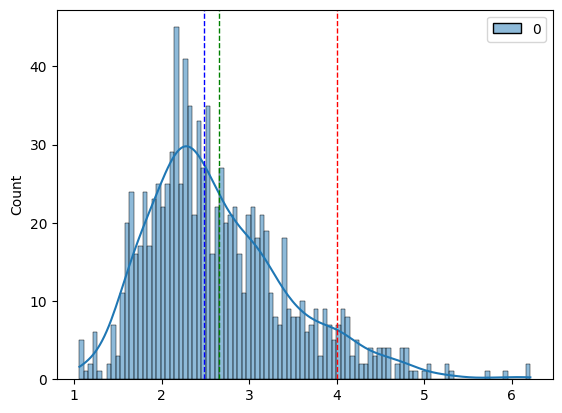

In [17]:
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

nbda=NBDA(covariates_data['network'], status) 
nbda.get_cov()


# Run model to recover parameters
m = bee()
m.data_on_model=dict(D_asocial = nbda.T_asocial, D_social = nbda.T_social, network = nbda.network, status = nbda.status)
m.run(model0, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

# Plot results
#plot_distributions(m.posteriors,  dict(alpha_asoc=alpha_asocial, alpha_soc=alpha_social), by_param=False)

import seaborn as sns
m.posteriors['alpha_soc'].mean()
print(jnp.median(m.posteriors['alpha_soc']))
print(jnp.mean(m.posteriors['alpha_soc']))
sns.histplot(m.posteriors['alpha_soc'], kde=True, bins = 100)
plt.axvline(alpha_social, color='r', linestyle='dashed', linewidth=1)
plt.axvline(m.posteriors['alpha_soc'].mean(), color='g', linestyle='dashed', linewidth=1)
plt.axvline(jnp.median(m.posteriors['alpha_soc']), color='b', linestyle='dashed', linewidth=1)
plt.show()

In [14]:
m = bi()
m.run(nbda.model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:35<00:00, 21.05it/s, 3 steps of size 5.09e-01. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated parameters
                     mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
asocial_learning[0] -4.00  0.39     -4.62      -3.40       0.02     0.01   
ces_alpha            0.97  0.02      0.94       1.00       0.00     0.00   
social_learning[0]   3.60  0.95      2.01       4.93       0.04     0.03   

                     ess_bulk  ess_tail  r_hat  
asocial_learning[0]    627.59    381.74    NaN  
ces_alpha              726.33    450.22    NaN  
social_learning[0]     798.74    735.96    NaN  


In [ ]:
m = bi()
m.data_on_model=dict(CES = False)
m.run(nbda.model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

jax.local_device_count 1
Simulated network with N =  200
Simulated diffusion  with rows representing individuals  200  and columns representing time steps. 1 = informed, 0 = uninformed


$$
        \text{Informed} = \text{Binomial}(\text{LK}) \newline
        \text{LK} = \left[ \theta + (1-\theta)S \right] (1- z_i) \newline
        \theta = \alpha_a \newline
        S = \alpha_s \left( \sum_{j = 1}^{N} A_{ij} z_{j} \right) \newline 
        \alpha_a\sim Normal(0,4) \newline
        \alpha_s \sim Normal(0,4) \newline
        $$

$$ \text{Informed} = Asocial Rate + Social Rate \newline$$

jax.local_device_count 1


sample: 100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s, 3 steps of size 5.22e-01. acc. prob=0.85] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated parameters
               mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha_asoc[0] -4.66  0.42     -5.36      -4.00       0.02     0.02    372.35   
alpha_soc[0]   3.81  1.45      1.71       5.84       0.08     0.06    403.61   

               ess_tail  r_hat  
alpha_asoc[0]    579.54    NaN  
alpha_soc[0]     365.60    NaN  
3.4397729752468855
3.8059754199230755


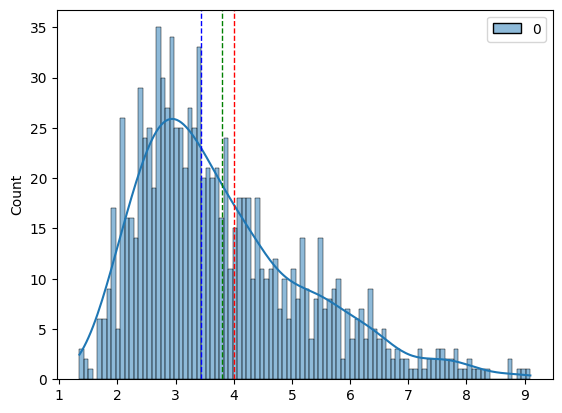

In [174]:
N=200 # Number of individuals
times=100 # number of time steps
m = bee(platform='cpu')
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([4])
alpha_asocial =jnp.array([-5])
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

nbda=NBDA(covariates_data['network'], status) 
nbda.get_cov()
nbda.print_model()

# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model0, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

# Plot results
#plot_distributions(m.posteriors,  dict(alpha_asoc=alpha_asocial, alpha_soc=alpha_social), by_param=False)

import seaborn as sns
m.posteriors['alpha_soc'].mean()
print(jnp.median(m.posteriors['alpha_soc']))
print(jnp.mean(m.posteriors['alpha_soc']))
sns.histplot(m.posteriors['alpha_soc'], kde=True, bins = 100)
plt.axvline(alpha_social, color='r', linestyle='dashed', linewidth=1)
plt.axvline(m.posteriors['alpha_soc'].mean(), color='g', linestyle='dashed', linewidth=1)
plt.axvline(jnp.median(m.posteriors['alpha_soc']), color='b', linestyle='dashed', linewidth=1)
plt.show()

# Main simulation function

This function runs the simulation as shown in the previous section and returns:

* The simulated data
* The true parameters
* The estimated parameters

In [ ]:
import gc
def main(N = 100, times = 30, alpha_social = jnp.array([-10]), alpha_asocial = jnp.array([-1]),
         print_network= False, print_status = False):
    """Main simulation function

    Args:
        N (int, optional): Number of individuals. Defaults to 100.
        times (int, optional): Number of time steps. Defaults to 30.
        alpha_social (jnp.array, optional): Coefficients for social effect covariates. Defaults to jnp.array([-10]).
        alpha_asocial (jnp.array, optional): Coefficients for asocial effect covariates. Defaults to jnp.array([-1]).
    """

    covariates_data = create_covariates(N=N, times=times, print_network= print_network,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'
    nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
    nbda.get_cov()

    # Set simulation parameters (those to recover)
    status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion
    #when = jnp.argmax(status == 1, axis=1)
    propPop = sum(status[:,-1])/N

    nbda=NBDA(covariates_data['network'], status) 
    nbda.get_cov()

    if print_status:
        heatmap(nbda.status)

    # Run model to recover parameters
    m = bi()
    m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
    m.run(model0, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
    summary = m.summary(kind = 'all')

    return summary, propPop


# Testing different scenarios
We will run main function to generate X simulations with different paramters

In [ ]:
import random as random2
import time
import gc
import csv

def sim_estimations(alphas_asocial, alphas_social, file = 'sim.csv',
                    print_network = False, print_status = False):

    Ns = jax.random.randint( jax.random.PRNGKey(int(time.time())), shape=(alphas_asocial.shape[0],), minval=50, maxval=200)
    NTimes = jax.random.randint( jax.random.PRNGKey(int(time.time()+1)), shape=(alphas_asocial.shape[0],), minval=50, maxval=100)

    with open(file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['asocial_mean', 'social_mean', 
                         'asocial_ci5', 'social_mean_ci5', 
                         'asocial_ci95', 'social_ci95', 
                         'N', 'T', 
                         'simAsoc', 'simSoc', 
                         "proportionInformed"])

    for i in range(alphas_asocial.shape[0]):
        print("Simulataion", i, "of", alphas_asocial.shape[0], "-------------------------------------------------------------")
        print("Estimation for alpha_social = ", alphas_social[i], " and alpha_asocial = ", alphas_asocial[i], " with N = ", Ns[i], " and times = ", NTimes[i])
        summary,  propPop = main(N = int(Ns[i]), times = int(NTimes[i]), alpha_social = jnp.array([alphas_social[i].item()]), alpha_asocial =  jnp.array([alphas_asocial[i].item()]),
                             print_network = print_network, print_status = print_status)
        print("Estimated alpha_social = ", summary[1]," / true alpha_social = ", alphas_social[i],  ";  and estimated alpha_asocial = ", summary[0], "/ true alpha_asocial = ",  alphas_asocial[i])

        with open(file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([summary['mean'][0], summary['mean'][1],
                             summary['hdi_5.5%'][0],summary['hdi_5.5%'][1],
                             summary['hdi_94.5%'][0],summary['hdi_94.5%'][1], 
                             Ns[i], NTimes[i], alphas_asocial[i], alphas_social[i],propPop])

        summary = propPop = None
        del summary, propPop
        gc.collect()
        


## No covariates, fixed null social effect and varying asocial effects

In [ ]:
# ! When asocial effect is to big every individual learn at time step 0 and there is no acquision through time
Nsim = 2
alphas_asocial = m.dist.uniform(-3, 1.5, sample = True, shape = (Nsim,))
alphas_social = jnp.repeat(-5,Nsim)
sim1 = sim_estimations(alphas_asocial = alphas_asocial,alphas_social = alphas_social, file = 'sim1.csv')

## No covariates, fixed null asocial effect and varying social effects

In [ ]:
alphas_social = bee.dist.uniform(-3, 3, sample = True, shape = (Nsim,))
alphas_asocial = jnp.repeat(-5,Nsim)
sim2 = sim_estimations(alphas_asocial = alphas_asocial,alphas_social = alphas_social, file = 'sim2.csv')

Simulataion 0 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -0.48925732970168134  and alpha_asocial =  -5  with N =  88  and times =  64
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:13<00:00, 143.47it/s, 1 steps of size 9.41e-01. acc. prob=0.90]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.15  / true alpha_social =  -0.48925732970168134 ;  and estimated alpha_asocial =  -5.01 / true alpha_asocial =  -5
Simulataion 1 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -1.7022272723669318  and alpha_asocial =  -5  with N =  156  and times =  51
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:27<00:00, 72.30it/s, 3 steps of size 7.63e-01. acc. prob=0.94] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -1.7  / true alpha_social =  -1.7022272723669318 ;  and estimated alpha_asocial =  -5.0 / true alpha_asocial =  -5
Simulataion 2 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  2.791928766713985  and alpha_asocial =  -5  with N =  144  and times =  82
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:50<00:00, 39.74it/s, 3 steps of size 4.70e-01. acc. prob=0.87] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  2.56  / true alpha_social =  2.791928766713985 ;  and estimated alpha_asocial =  -5.19 / true alpha_asocial =  -5
Simulataion 3 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.4470032023650279  and alpha_asocial =  -5  with N =  83  and times =  91
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:22<00:00, 90.84it/s, 3 steps of size 8.11e-01. acc. prob=0.92]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.65  / true alpha_social =  0.4470032023650279 ;  and estimated alpha_asocial =  -4.99 / true alpha_asocial =  -5
Simulataion 4 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.1933589295032565  and alpha_asocial =  -5  with N =  129  and times =  98
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:40<00:00, 49.94it/s, 3 steps of size 9.30e-01. acc. prob=0.91] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.16  / true alpha_social =  0.1933589295032565 ;  and estimated alpha_asocial =  -5.17 / true alpha_asocial =  -5
Simulataion 5 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -0.8705689183815344  and alpha_asocial =  -5  with N =  182  and times =  87
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:07<00:00, 29.47it/s, 3 steps of size 8.00e-01. acc. prob=0.92] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -0.94  / true alpha_social =  -0.8705689183815344 ;  and estimated alpha_asocial =  -5.11 / true alpha_asocial =  -5
Simulataion 6 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  2.298053856953942  and alpha_asocial =  -5  with N =  112  and times =  74
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:37<00:00, 53.38it/s, 3 steps of size 2.98e-01. acc. prob=0.92] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  2.92  / true alpha_social =  2.298053856953942 ;  and estimated alpha_asocial =  -4.67 / true alpha_asocial =  -5
Simulataion 7 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.7953623417784859  and alpha_asocial =  -5  with N =  57  and times =  84
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:26<00:00, 76.28it/s, 3 steps of size 3.34e-01. acc. prob=0.90]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  2.62  / true alpha_social =  0.7953623417784859 ;  and estimated alpha_asocial =  -4.98 / true alpha_asocial =  -5
Simulataion 8 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.2028004604628748  and alpha_asocial =  -5  with N =  142  and times =  99
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:49<00:00, 40.01it/s, 1 steps of size 9.20e-01. acc. prob=0.91] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.34  / true alpha_social =  0.2028004604628748 ;  and estimated alpha_asocial =  -5.2 / true alpha_asocial =  -5
Simulataion 9 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -1.8500767111244807  and alpha_asocial =  -5  with N =  84  and times =  79
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:14<00:00, 134.32it/s, 3 steps of size 9.49e-01. acc. prob=0.90] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -2.07  / true alpha_social =  -1.8500767111244807 ;  and estimated alpha_asocial =  -4.76 / true alpha_asocial =  -5
Simulataion 10 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  2.125059911727947  and alpha_asocial =  -5  with N =  87  and times =  71
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:26<00:00, 74.40it/s, 7 steps of size 3.41e-01. acc. prob=0.87]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  1.99  / true alpha_social =  2.125059911727947 ;  and estimated alpha_asocial =  -5.04 / true alpha_asocial =  -5
Simulataion 11 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -2.643364255265748  and alpha_asocial =  -5  with N =  98  and times =  91
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:26<00:00, 74.13it/s, 3 steps of size 7.89e-01. acc. prob=0.92] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -2.55  / true alpha_social =  -2.643364255265748 ;  and estimated alpha_asocial =  -4.97 / true alpha_asocial =  -5
Simulataion 12 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.860350274055731  and alpha_asocial =  -5  with N =  191  and times =  69
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:00<00:00, 32.99it/s, 3 steps of size 8.17e-01. acc. prob=0.90] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  1.15  / true alpha_social =  0.860350274055731 ;  and estimated alpha_asocial =  -5.36 / true alpha_asocial =  -5
Simulataion 13 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  2.9644270079650696  and alpha_asocial =  -5  with N =  177  and times =  64
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:03<00:00, 31.71it/s, 3 steps of size 7.06e-01. acc. prob=0.79] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  5.2  / true alpha_social =  2.9644270079650696 ;  and estimated alpha_asocial =  -4.76 / true alpha_asocial =  -5
Simulataion 14 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.6120876862924955  and alpha_asocial =  -5  with N =  158  and times =  51
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:33<00:00, 59.75it/s, 3 steps of size 7.90e-01. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.63  / true alpha_social =  0.6120876862924955 ;  and estimated alpha_asocial =  -5.21 / true alpha_asocial =  -5
Simulataion 15 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -0.6701030877211429  and alpha_asocial =  -5  with N =  142  and times =  62
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:31<00:00, 62.63it/s, 1 steps of size 8.53e-01. acc. prob=0.92] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -0.56  / true alpha_social =  -0.6701030877211429 ;  and estimated alpha_asocial =  -5.34 / true alpha_asocial =  -5
Simulataion 16 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -1.2197494544752958  and alpha_asocial =  -5  with N =  75  and times =  55
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:11<00:00, 169.04it/s, 3 steps of size 9.14e-01. acc. prob=0.91] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -1.17  / true alpha_social =  -1.2197494544752958 ;  and estimated alpha_asocial =  -5.16 / true alpha_asocial =  -5
Simulataion 17 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.8612632827580176  and alpha_asocial =  -5  with N =  157  and times =  92
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:10<00:00, 28.18it/s, 3 steps of size 7.11e-01. acc. prob=0.93] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  1.25  / true alpha_social =  0.8612632827580176 ;  and estimated alpha_asocial =  -5.05 / true alpha_asocial =  -5
Simulataion 18 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -0.46608542800133623  and alpha_asocial =  -5  with N =  189  and times =  63
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:54<00:00, 36.52it/s, 3 steps of size 7.79e-01. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -0.66  / true alpha_social =  -0.46608542800133623 ;  and estimated alpha_asocial =  -4.71 / true alpha_asocial =  -5
Simulataion 19 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  2.602315214332208  and alpha_asocial =  -5  with N =  96  and times =  93
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:36<00:00, 54.18it/s, 7 steps of size 3.70e-01. acc. prob=0.94] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  1.82  / true alpha_social =  2.602315214332208 ;  and estimated alpha_asocial =  -4.9 / true alpha_asocial =  -5
Simulataion 20 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.14126087150745503  and alpha_asocial =  -5  with N =  122  and times =  69
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:27<00:00, 71.63it/s, 3 steps of size 8.27e-01. acc. prob=0.93] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.18  / true alpha_social =  0.14126087150745503 ;  and estimated alpha_asocial =  -4.96 / true alpha_asocial =  -5
Simulataion 21 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.33776777677392733  and alpha_asocial =  -5  with N =  78  and times =  58
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:19<00:00, 102.83it/s, 3 steps of size 3.80e-01. acc. prob=0.91] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  1.12  / true alpha_social =  0.33776777677392733 ;  and estimated alpha_asocial =  -4.86 / true alpha_asocial =  -5
Simulataion 22 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.44858265494957994  and alpha_asocial =  -5  with N =  87  and times =  85
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:22<00:00, 89.47it/s, 3 steps of size 7.92e-01. acc. prob=0.93] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -0.35  / true alpha_social =  0.44858265494957994 ;  and estimated alpha_asocial =  -4.95 / true alpha_asocial =  -5
Simulataion 23 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.11181313028307649  and alpha_asocial =  -5  with N =  158  and times =  80
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:50<00:00, 39.95it/s, 3 steps of size 7.80e-01. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.29  / true alpha_social =  0.11181313028307649 ;  and estimated alpha_asocial =  -5.14 / true alpha_asocial =  -5
Simulataion 24 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -2.527465519589181  and alpha_asocial =  -5  with N =  158  and times =  90
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:50<00:00, 40.00it/s, 3 steps of size 9.46e-01. acc. prob=0.89]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -2.23  / true alpha_social =  -2.527465519589181 ;  and estimated alpha_asocial =  -5.12 / true alpha_asocial =  -5
Simulataion 25 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -0.4637351605012574  and alpha_asocial =  -5  with N =  69  and times =  89
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:18<00:00, 110.23it/s, 3 steps of size 7.30e-01. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -1.02  / true alpha_social =  -0.4637351605012574 ;  and estimated alpha_asocial =  -4.97 / true alpha_asocial =  -5
Simulataion 26 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  2.2029063709416055  and alpha_asocial =  -5  with N =  140  and times =  81
jax.local_device_count 32


  0%|          | 0/2000 [00:00<?, ?it/s]

: 

## No covariates, varying asocial and varying social effects

jax.local_device_count 16
Estimation for alpha_social =  -1.1198365316277994  and alpha_asocial =  -1.9730588529130235  with N =  103  and times =  94
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [01:02<00:00, 31.83it/s, 3 steps of size 8.59e-01. acc. prob=0.91] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -0.15  / true alpha_social =  -1.1198365316277994 ;  and estimated alpha_asocial =  -2.11 / true alpha_asocial =  -1.9730588529130235
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  -1.362082228745861  and alpha_asocial =  0.7203069200897781  with N =  133  and times =  76
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:29<00:00, 67.80it/s, 3 steps of size 5.30e-01. acc. prob=0.89]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -2.96  / true alpha_social =  -1.362082228745861 ;  and estimated alpha_asocial =  0.93 / true alpha_asocial =  0.7203069200897781
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  0.16603362129473997  and alpha_asocial =  -0.7417228928489731  with N =  95  and times =  80
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:32<00:00, 62.23it/s, 3 steps of size 4.94e-01. acc. prob=0.87]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  2.86  / true alpha_social =  0.16603362129473997 ;  and estimated alpha_asocial =  -0.89 / true alpha_asocial =  -0.7417228928489731
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  -1.9054292036140603  and alpha_asocial =  -2.9081410479089076  with N =  119  and times =  56
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:55<00:00, 36.07it/s, 3 steps of size 8.51e-01. acc. prob=0.91] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -1.98  / true alpha_social =  -1.9054292036140603 ;  and estimated alpha_asocial =  -2.71 / true alpha_asocial =  -2.9081410479089076
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  -1.5914135000789733  and alpha_asocial =  1.481329138060252  with N =  146  and times =  81
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:26<00:00, 75.28it/s, 3 steps of size 7.41e-01. acc. prob=0.85]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.5  / true alpha_social =  -1.5914135000789733 ;  and estimated alpha_asocial =  1.39 / true alpha_asocial =  1.481329138060252
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  1.3992329721902061  and alpha_asocial =  -2.08734352901207  with N =  150  and times =  80
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:50<00:00, 39.49it/s, 3 steps of size 6.57e-01. acc. prob=0.81] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  4.69  / true alpha_social =  1.3992329721902061 ;  and estimated alpha_asocial =  -2.02 / true alpha_asocial =  -2.08734352901207
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  -0.16943106000917396  and alpha_asocial =  -1.0765783748756013  with N =  131  and times =  79
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:33<00:00, 59.91it/s, 3 steps of size 4.59e-01. acc. prob=0.92]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  1.01  / true alpha_social =  -0.16943106000917396 ;  and estimated alpha_asocial =  -0.97 / true alpha_asocial =  -1.0765783748756013
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  -0.9047718706146829  and alpha_asocial =  0.8847525431963277  with N =  175  and times =  67
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:38<00:00, 52.44it/s, 3 steps of size 5.83e-01. acc. prob=0.88] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -3.49  / true alpha_social =  -0.9047718706146829 ;  and estimated alpha_asocial =  1.0 / true alpha_asocial =  0.8847525431963277
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  -0.2832592951958808  and alpha_asocial =  0.10475934657280483  with N =  172  and times =  55
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:31<00:00, 63.24it/s, 7 steps of size 4.07e-01. acc. prob=0.80]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -2.73  / true alpha_social =  -0.2832592951958808 ;  and estimated alpha_asocial =  0.18 / true alpha_asocial =  0.10475934657280483
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  -0.2853615860746782  and alpha_asocial =  0.6338159383923957  with N =  68  and times =  51
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:10<00:00, 191.17it/s, 3 steps of size 7.51e-01. acc. prob=0.87]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.92  / true alpha_social =  -0.2853615860746782 ;  and estimated alpha_asocial =  0.62 / true alpha_asocial =  0.6338159383923957
-------------------------------------------------------------


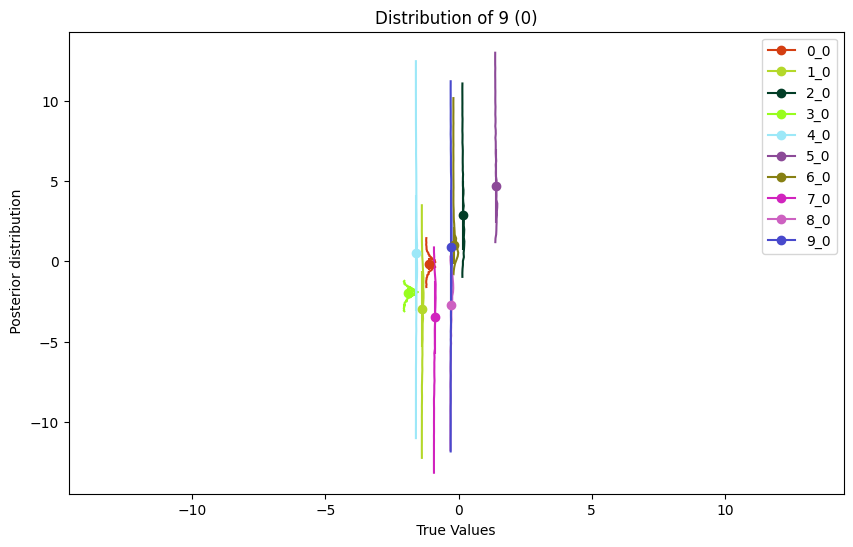

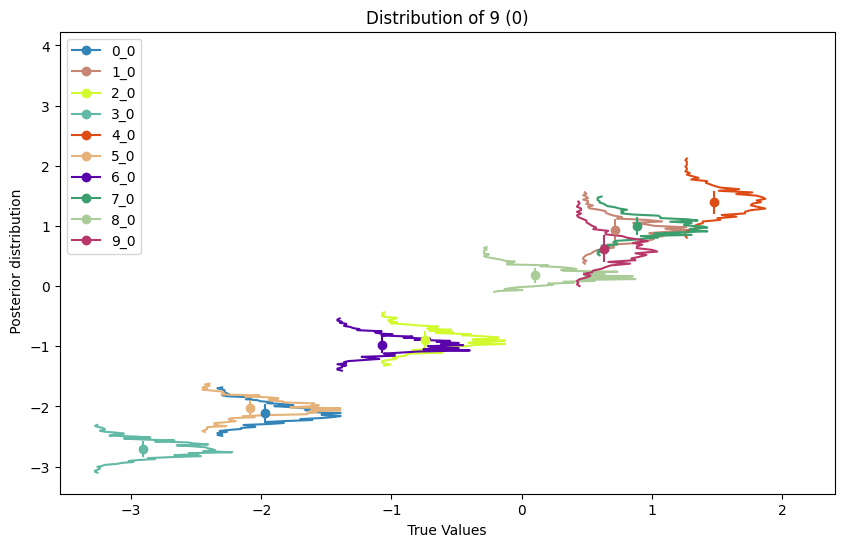

In [ ]:
alphas_social = bee.dist.uniform(-3, 3, sample = True, shape = (Nsim,), seed = 1)
alphas_asocial = bee.dist.uniform(-3, 3, sample = True, shape = (Nsim,), seed = 100)
sim3 = sim_estimations(alphas_asocial = alphas_asocial,alphas_social = alphas_social, file = 'sim3.csv')

## With covariates
Due to issues related to long tail posterior distribution for social rate when true social transmission rate is strong, we will fix social and asocial rates to a value that is not too strong but still present and incorporate covariates effects one by one and evaluate there correct estimation.

### Model with covariates
The intercept have its own prior set to 0, 5 as we specify a large prior (invert logit of 5 is 0.993). The covariates have their own priors set to 0, 1 as we consider them as scaled


In [13]:
def model(D_asocial, D_social, network, status2 = None, status = None):
    if status is None:
        status = status2
    N = status.shape[0] # Number of individuals
    T = status.shape[1] # Number of time steps
    P = status.shape[2] # Number of processes
    lk = jnp.zeros((N,T, P))

    # Priors for social effect covariates
    alpha_soc = m.dist.normal(0, 5, shape = (1,), sample=False, name='alpha_soc')
    betas_soc = m.dist.normal(0, 1, shape = (D_social.shape[3]-1,), sample=False, name='betas_soc')
    soc = jnp.concatenate((alpha_soc, betas_soc))

    # Priors for asocial effect covariates
    alpha_asoc = m.dist.normal(0, 5,  shape = (1,), sample=False, name='alpha_asoc')
    betas_asoc = m.dist.normal(0, 1, shape = (D_asocial.shape[2]-1,), sample=False, name='betas_asoc')
    asoc = jnp.concatenate((alpha_asoc, betas_asoc))

    # Asocial learning -----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], asoc, axes=(-1, 0))    
    theta = m.link.inv_logit(R_asocial)
    lk = lk.at[:,0, 0].set(theta)

    for t in range(1,T):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], soc, axes=(-1, 0))
        phi = m.link.inv_logit(R_social)
        attention_weigthed_network = phi*network[:,:,t,0]
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc, axes=(-1, 0))
        theta = m.link.inv_logit(R_asocial)
        # Informed update at t!= 0-----------------------
        lk = lk.at[:,t, 0].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))

    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        #m.binomial(probs=lk, obs=status[:,:,0])
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status)

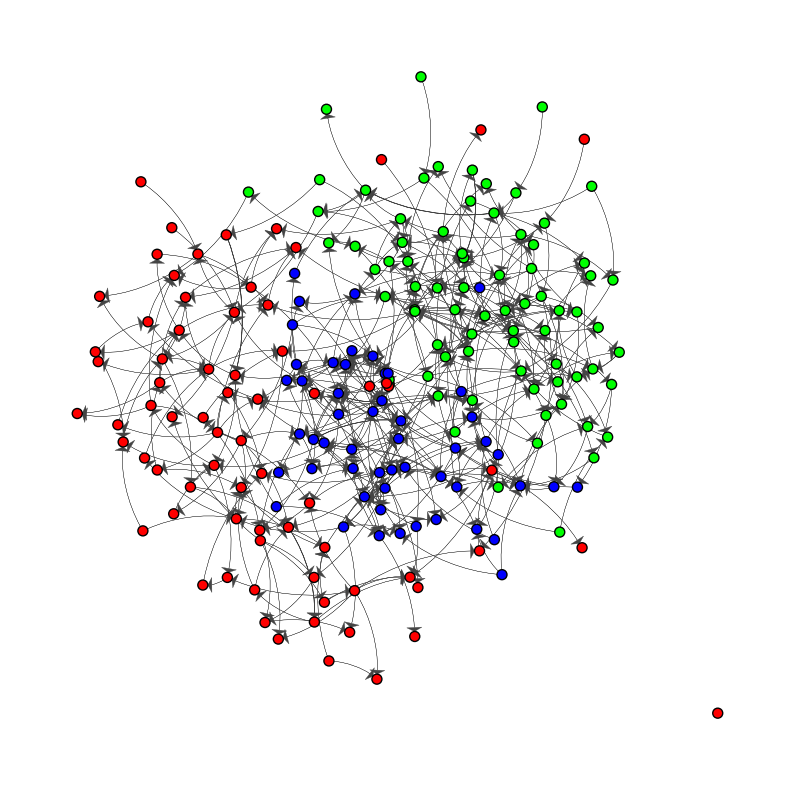

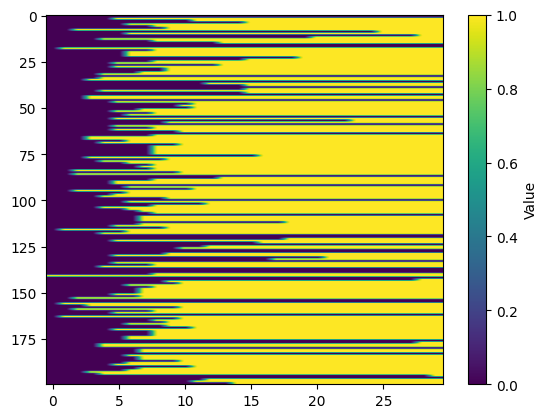

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:26<00:00, 75.94it/s, 3 steps of size 8.06e-01. acc. prob=0.92] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


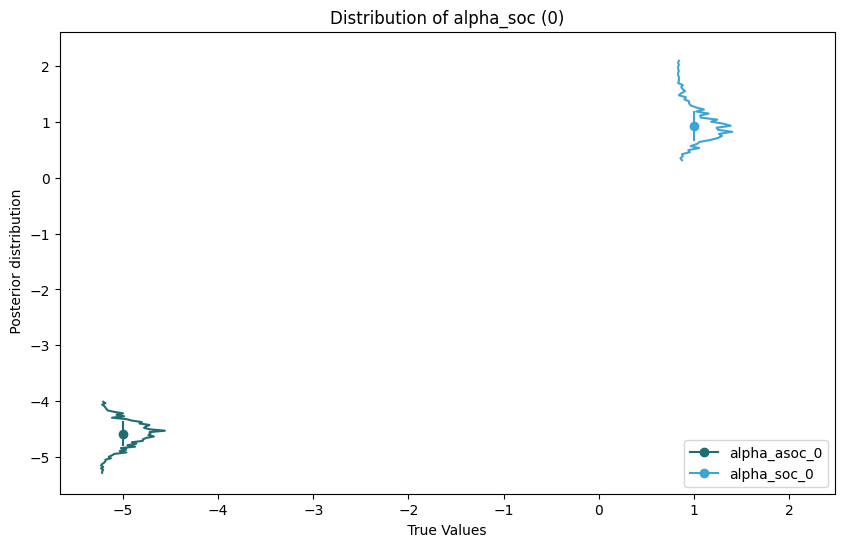

In [ ]:
nbdaObject, means, m, covariates_data = main(N = 200, 
                                             times = 30,
                                             alpha_social = jnp.array([1]), 
                                             alpha_asocial = jnp.array([-5]),
                                             print_network= True, print_status = True)
plot_distributions(m.posteriors,  dict(alpha_asoc=jnp.array([-5]), alpha_soc=jnp.array([1])))

So the main simulation data will always have asocial rate set to -5 (nonexistent) and so social rate set to 1 (0.75).



### Nodal Fixed covariate

In [ ]:
import pandas as pd
m = bi()
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

# ! Dummy nbda object with no status to initialize data for the diffusion process
nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.import_covNF(pd.DataFrame(covariates_data['covF'])) # ! Import nodal fixed covariate data to affect diffusion process
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1, 0, 0 ]) #! covNF will have an effect of 0 (i.e. 0.5) we need 2 coefficients, one for covNF_i and one for covNF_j
alpha_asocial =jnp.array([-5, -1]) #! covNF will have an effect of -5 (i.e. noneexistent)
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

#! update nbda object with diffusion process simulated 
nbda=NBDA(covariates_data['network'], status) 
nbda.import_covNF(pd.DataFrame(covariates_data['covF']))
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

# Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=[alpha_asocial[0]], alpha_soc=[alpha_social[0]],
                                       betas_asoc =  alpha_asocial[1:], betas_soc = alpha_social[1:]), by_param = False)

jax.local_device_count 32
Simulated network with N =  200
Simulated diffusion  with rows representing individuals  200  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 32


  0%|          | 0/2000 [00:00<?, ?it/s]

### Nodal time varying covariate
#### Scaling the covariate within each time steps

In [ ]:
import pandas as pd
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

# ! Dummy nbda object with no status to initialize data for the diffusion process
nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) # ! Import nodal fixed covariate data to affect diffusion process
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) # ! Import nodal time-varying covariate data to affect diffusion process
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1, 0, 0, 0, 0 ]) #! covNF will have an effect of 0 (i.e. 0.5) we need 2 coefficients, one for covNF_i and one for covNF_j
alpha_asocial =jnp.array([-5, -5, -5]) #! covNF will have an effect of -5 (i.e. noneexistent)
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

#! update nbda object with diffusion process simulated 
nbda=NBDA(covariates_data['network'], status) 
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) 
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) # ! Import nodal time-varying covariate data to affect diffusion process
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=500, num_warmup=500, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

## Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=[alpha_asocial[0]], betas_asoc=alpha_asocial[1:],
                                       alpha_soc=[alpha_social[0]], betas_soc=alpha_social[1:]), by_param = False)

kde(m.posteriors['alpha_soc'],  original_value=alpha_social[0])


In [ ]:
NV_save = m 

#### QQ-plot

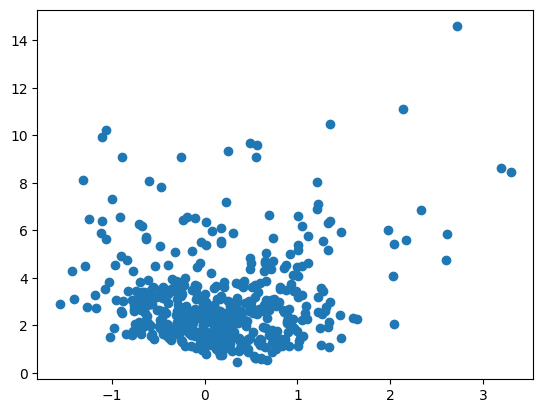

In [ ]:
plt.scatter(m.posteriors['betas_soc'][:,4], m.posteriors['alpha_soc'])

alpha_asoc


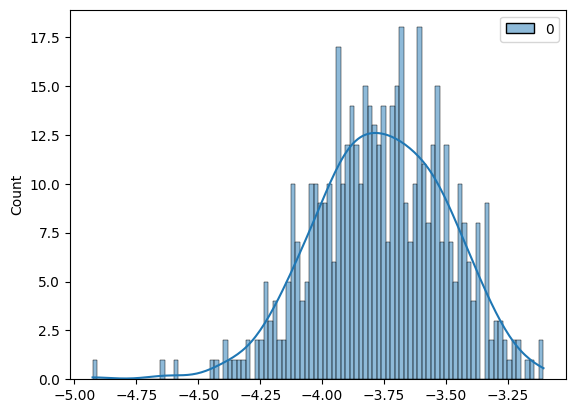

alpha_soc


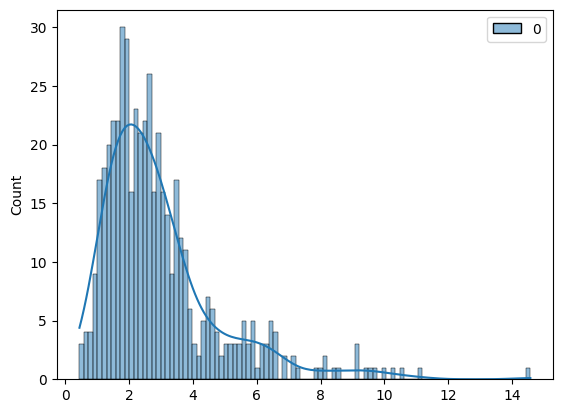

betas_asoc


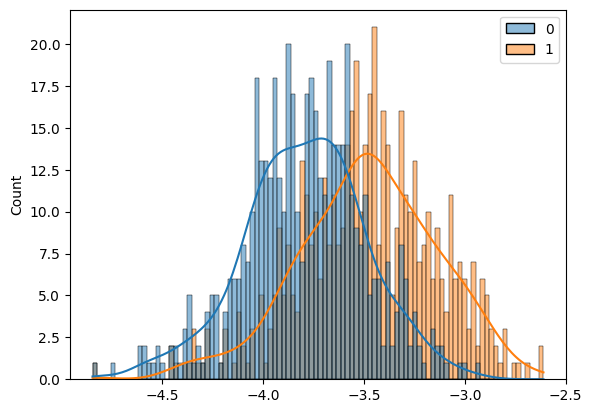

betas_soc


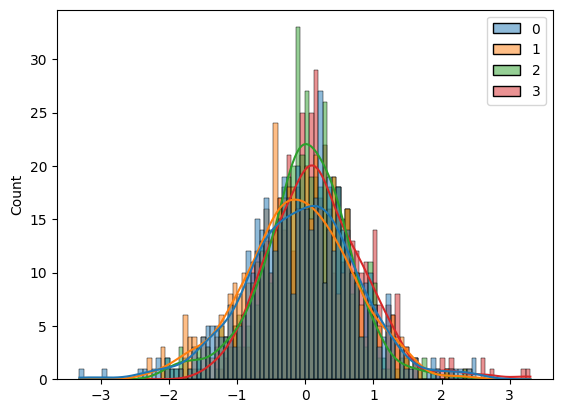

In [ ]:
for k in m.posteriors.keys():
    print(k)
    sns.histplot(m.posteriors[k], kde=True, bins = 100)
    plt.show()
    plt.close()

/tmp/ipykernel_218917/624485197.py:3: UserWarning: Sample's batch dimension size 500 is different from the provided 1000 num_samples argument. Defaulting to 500.
  predictive = Predictive(model, m.posteriors, num_samples=1000)


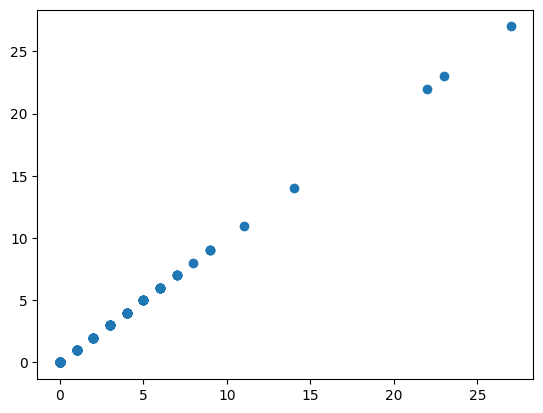

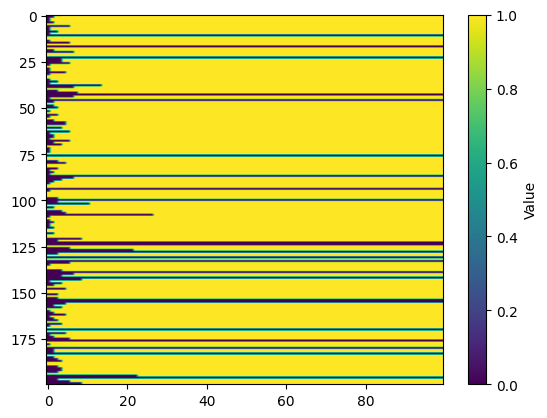

In [ ]:
from numpyro.infer import Predictive
def predict(model, m, nbdaObject):
    predictive = Predictive(model, m.posteriors, num_samples=1000)
    rng_key = jax.random.PRNGKey(1)
    preds = predictive(rng_key, D_asocial = nbdaObject.D_asocial, D_social = nbdaObject.D_social, network = nbdaObject.network, status2 = nbdaObject.status)

    meanPred = jnp.mean(preds['y'][:,:,:,0], axis=0)
    plt.scatter(jnp.argmax(nbdaObject.status, axis=1)[:,0],
            jnp.argmax(meanPred, axis=1))
    plt.show()
    heatmap(meanPred)
    return preds
preds = predict(model, m, nbda)

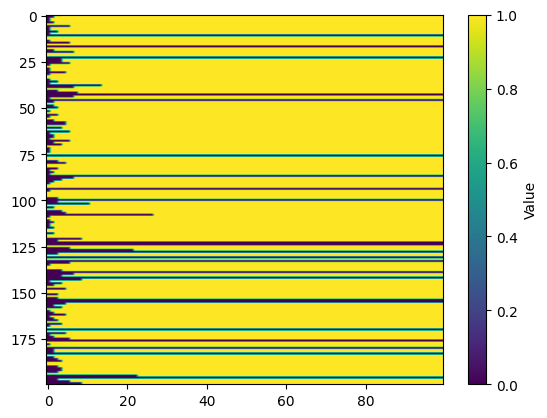

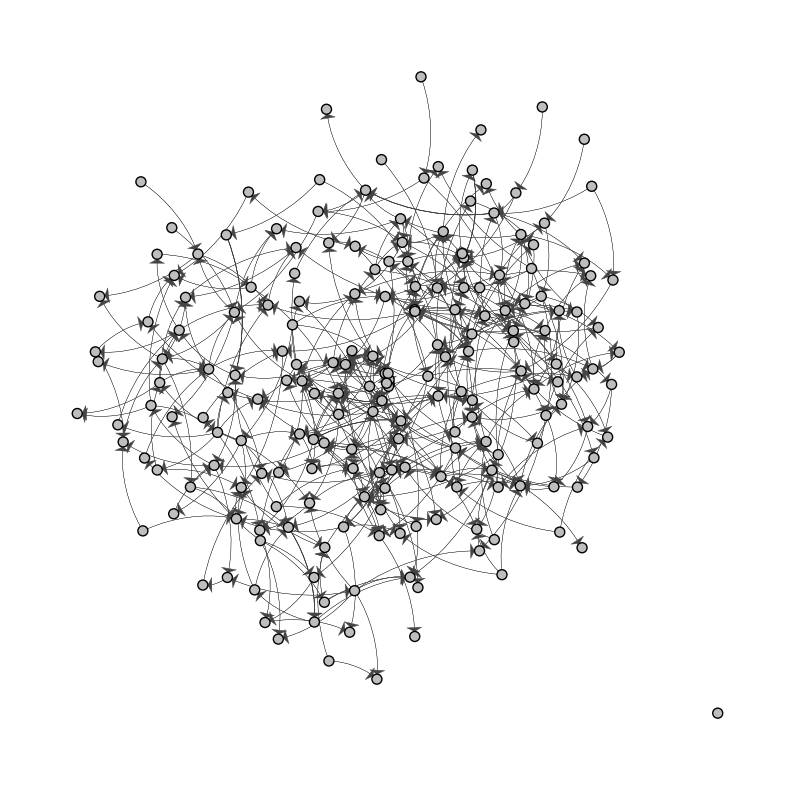

In [ ]:
heatmap(nbda.status)
viz_network(nbda.network[:,:,0,0], )

### Dyadic fixed covariate

Simulated network with N =  200
Simulated diffusion  with rows representing individuals  200  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s, 7 steps of size 2.96e-01. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


Estimated parameters
               mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha_asoc[0] -4.13  0.29     -4.57      -3.66       0.02     0.01    325.14   
alpha_soc[0]   1.21  0.63      0.28       1.98       0.05     0.04    167.70   
betas_asoc[0] -3.70  0.30     -4.13      -3.19       0.02     0.01    321.17   
betas_asoc[1] -3.40  0.34     -3.97      -2.88       0.02     0.01    290.30   
betas_soc[0]  -0.46  0.55     -1.29       0.36       0.03     0.03    312.92   
betas_soc[1]   0.25  0.40     -0.39       0.83       0.03     0.02    272.93   
betas_soc[2]   0.04  0.41     -0.58       0.67       0.02     0.02    345.22   
betas_soc[3]   0.37  0.40     -0.21       0.89       0.02     0.02    427.31   
betas_soc[4]   0.60  0.76     -0.59       1.79       0.04     0.03    356.88   

               ess_tail  r_hat  
alpha_asoc[0]    470.50    NaN  
alpha_soc[0]     194.42    NaN  
betas_asoc[0]    384.65    NaN  
betas_asoc[1]    406.36    NaN  
betas_soc[0] 

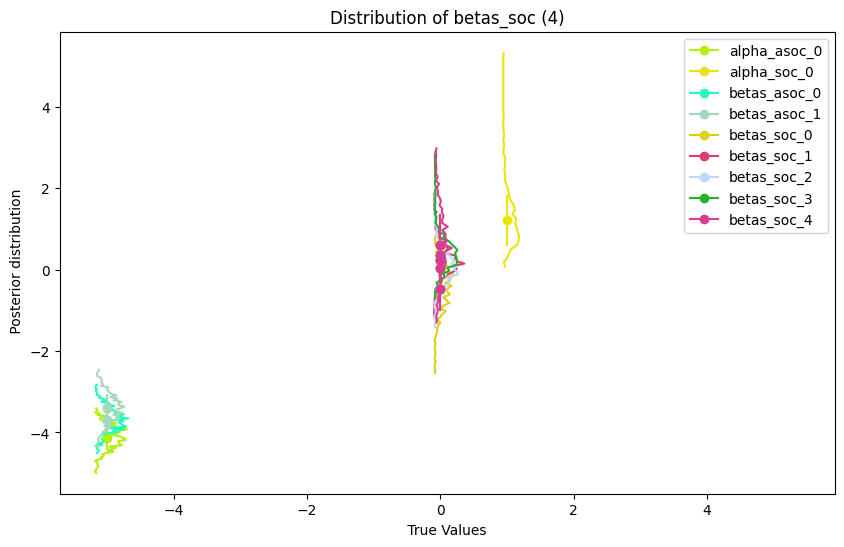

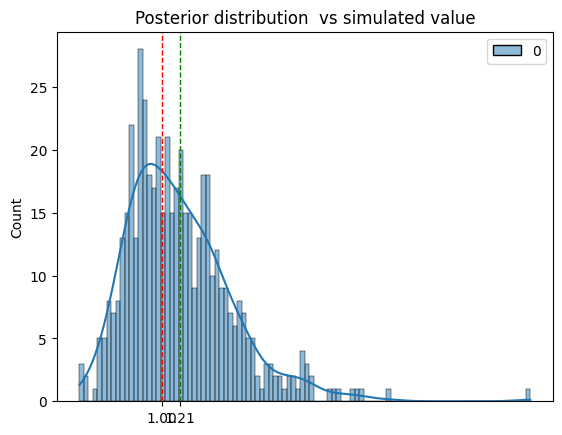

In [ ]:
import pandas as pd
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

# ! Dummy nbda object with no status to initialize data for the diffusion process
nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) # ! Import nodal fixed covariate data to affect diffusion process
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) # ! Import nodal time-varying covariate data to affect diffusion process
nbda.import_covDF(covariates_data['covDF'][:,:,0]) # ! Import dyadic fixed covariate data to affect diffusion process
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1, 0, 0, 0, 0, 0]) #! Dyadic covariates already have i and j, so a single coefficient
alpha_asocial =jnp.array([-5, -5, -5]) #! No dyadic covariates for asocial learning
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

#! update nbda object with diffusion process simulated 
nbda=NBDA(covariates_data['network'], status) 
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) 
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) 
nbda.import_covDF(covariates_data['covDF'][:,:,0])
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=500, num_warmup=500, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

## Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=[alpha_asocial[0]], betas_asoc=alpha_asocial[1:],
                                       alpha_soc=[alpha_social[0]], betas_soc=alpha_social[1:]), by_param = False)

kde(m.posteriors['alpha_soc'],  original_value=alpha_social[0])


### Dyadic time-varying covariates
#### Scaling dyadic time-varying covariates

Simulated network with N =  200
Simulated diffusion  with rows representing individuals  200  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [09:05<00:00,  1.83it/s, 15 steps of size 2.62e-01. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


Estimated parameters
               mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha_asoc[0] -2.96  0.34     -3.44      -2.41       0.02     0.01    444.12   
alpha_soc[0]  -0.90  0.48     -1.56      -0.08       0.03     0.02    278.28   
betas_asoc[0] -2.11  0.30     -2.55      -1.63       0.01     0.01    497.55   
betas_asoc[1] -1.04  0.21     -1.42      -0.75       0.01     0.01    375.29   
betas_soc[0]   0.90  0.46      0.20       1.64       0.03     0.02    317.54   
betas_soc[1]   0.45  0.56     -0.40       1.36       0.03     0.02    383.84   
betas_soc[2]   1.57  0.63      0.51       2.45       0.03     0.02    640.24   
betas_soc[3]   1.30  0.37      0.78       1.94       0.02     0.01    417.56   
betas_soc[4]   0.71  0.86     -0.69       2.02       0.03     0.03    716.91   
betas_soc[5]   1.33  0.62      0.29       2.26       0.02     0.02    657.68   

               ess_tail  r_hat  
alpha_asoc[0]    355.82    NaN  
alpha_soc[0]     300.67    NaN  

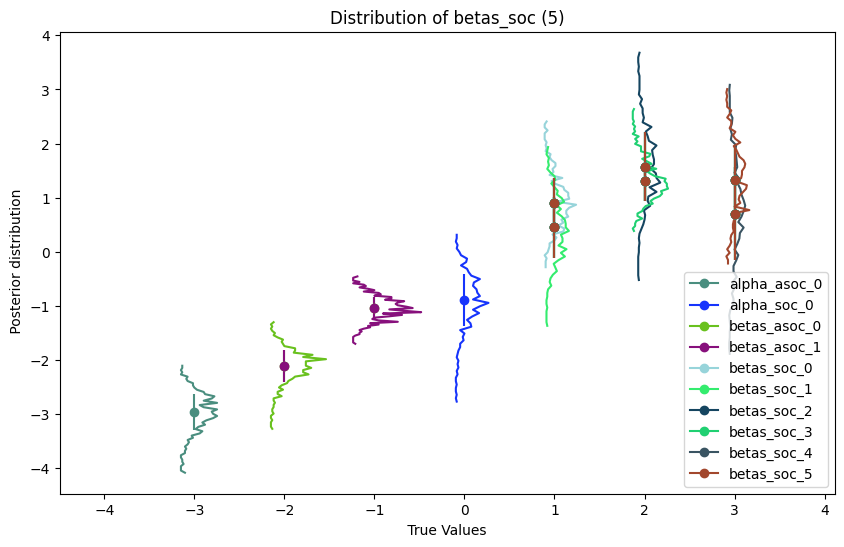

NameError: name 'sns' is not defined

In [ ]:
import pandas as pd
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

# ! Dummy nbda object with no status to initialize data for the diffusion process
nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) # ! Import nodal fixed covariate data to affect diffusion process
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) # ! Import nodal time-varying covariate data to affect diffusion process
nbda.import_covDF(covariates_data['covDF'][:,:,0]) # ! Import dyadic fixed covariate data to affect diffusion process
nbda.import_covDV(covariates_data['covDV']) # ! Import dyadic fixed covariate data to affect diffusion process
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([0, 1, 1, 2, 2, 3, 3]) 
alpha_asocial =jnp.array([-3, -2, -1]) #! No dyadic covariates for asocial learning
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

#! update nbda object with diffusion process simulated 
nbda=NBDA(covariates_data['network'], status) 
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) 
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) 
nbda.import_covDF(covariates_data['covDF'][:,:,0])
nbda.import_covDV(covariates_data['covDV'])
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=500, num_warmup=500, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

## Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=[alpha_asocial[0]], betas_asoc=alpha_asocial[1:],
                                       alpha_soc=[alpha_social[0]], betas_soc=alpha_social[1:]), by_param = False)

kde(m.posteriors['alpha_soc'],  original_value=alpha_social[0])


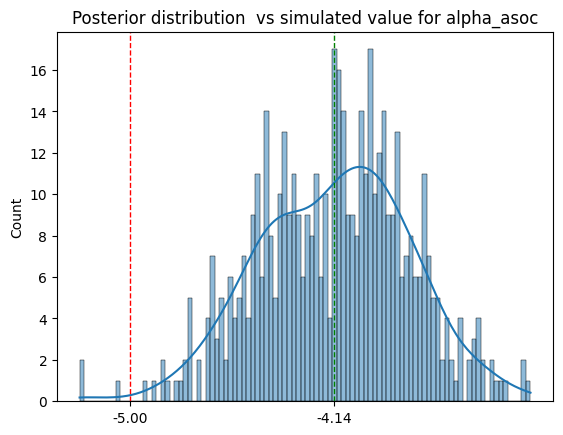

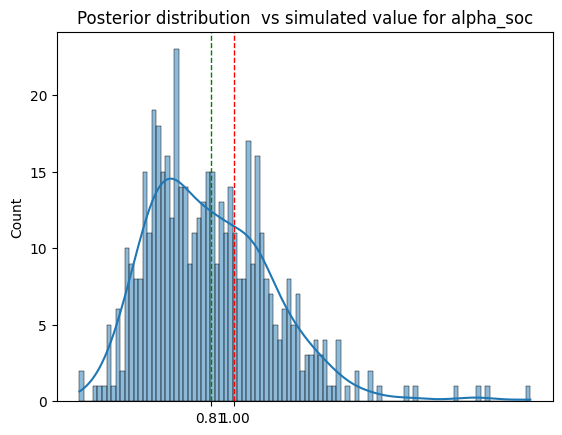

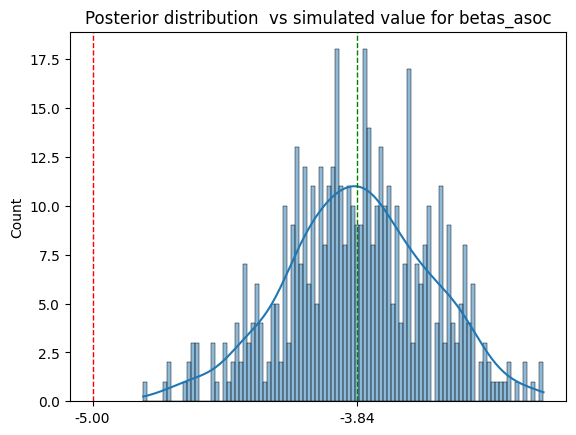

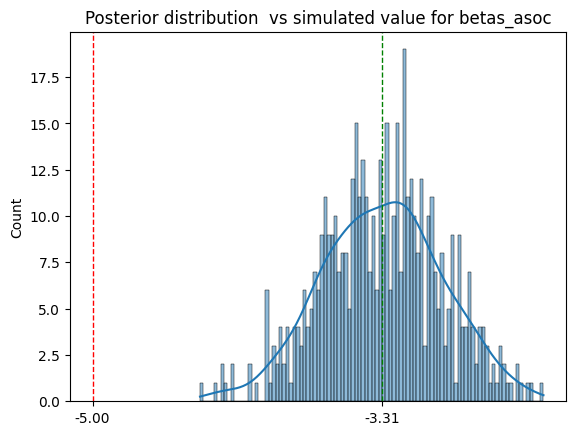

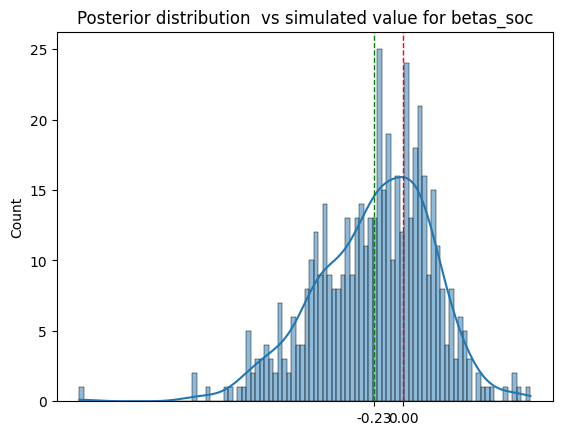

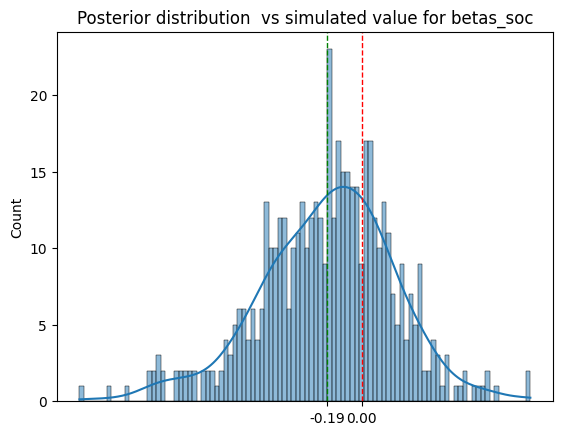

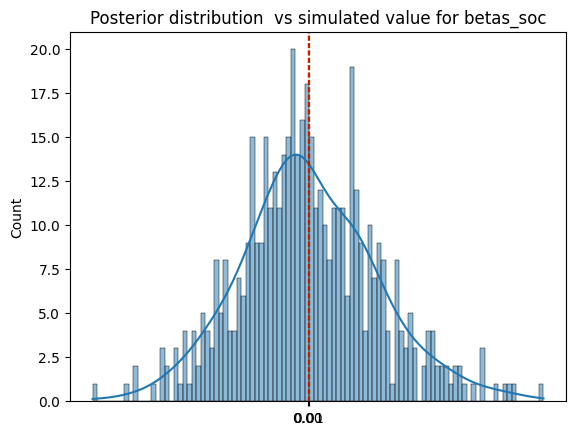

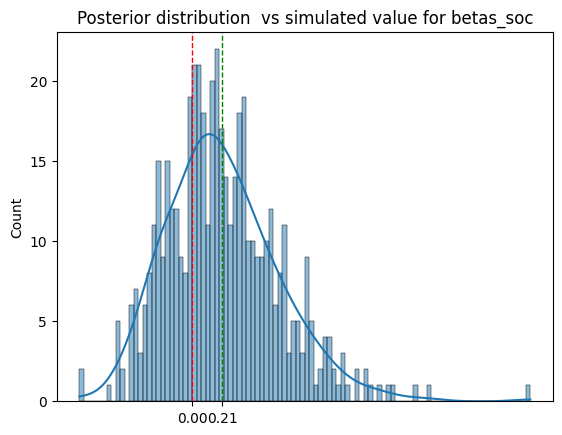

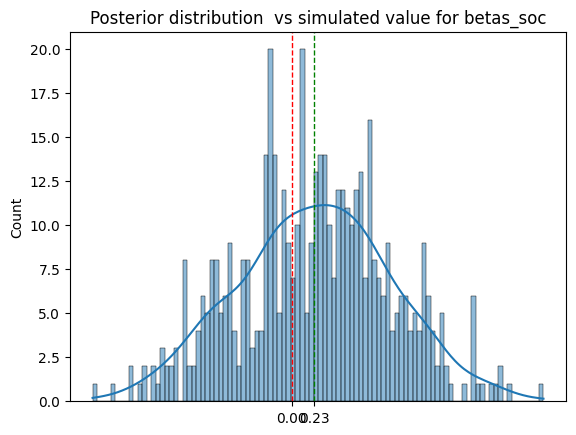

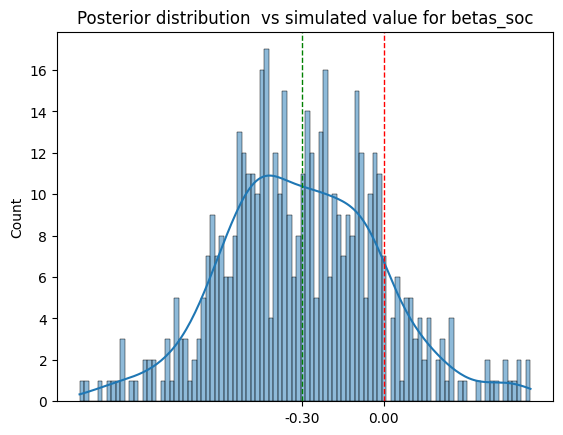

In [ ]:
params_kde(m, alpha_asocial=alpha_asocial, alpha_social= alpha_social)

## Testing R data

In [12]:
import json
import pandas as pd
with open('R_data.json', 'r') as file:
    data = json.load(file)
data.keys()

dict_keys(['N_networktypes', 'N_id', 'N_responses', 'N_periods', 'N_individual_predictors', 'N_dyadic_predictors', 'outcomes', 'flows', 'N_block_predictors', 'N_groups_per_block_type', 'outcome_mode', 'link_mode', 'exposure', 'mask', 'sampled', 'detected', 'sampled_exposure', 'detected_exposure', 'sampled_mask', 'detected_mask', 'diffusion_outcomes', 'diffusion_exposure', 'diffusion_mask', 'imputation', 'dyad_set', 'focal_set', 'target_set', 'N_params', 'block_set', 'N_group_vars', 'N_groups_per_var', 'max_N_groups', 'ind_focal_set', 'export_network', 'priors'])

In [13]:
rnet = jnp.array(data['outcomes'])
print(rnet.shape)
rexposure = jnp.array(data['exposure'])
print(rexposure.shape)
rstatus = jnp.array(data['diffusion_outcomes'])
print(rstatus.shape)
rcovNF = jnp.array(data['focal_set'])
print(rcovNF.shape) # issue shape = (N,V,T)
rcovDF = jnp.array(data['dyad_set'])
print(rcovDF.shape)

(100, 100, 150)
(100, 100, 150)
(100, 150)
(100, 3, 150)
(100, 100, 3, 150)


In [14]:
nbda = NBDA(rnet[:,:,0]/rexposure[:,:,0], rstatus)
nbda.import_covNF(pd.DataFrame(rcovNF[:,1:,0]), names = ['Gold', 'Mass'], scale = False)
nbda.import_covDF(rcovDF[:,:,1:,0], names = ['Kinship', 'Dominant'], scale = False)
nbda.get_cov()
nbda.T_social_names

['social_learning',
 'covNF_i_Gold',
 'covNF_i_Mass',
 'covNF_j_Gold',
 'covNF_j_Mass',
 'covDF_Kinship',
 'covDF_Dominant']

In [15]:
#! Using R data
m = bi()
m.run(nbda.model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

jax.local_device_count 1


sample: 100%|██████████| 2000/2000 [17:42<00:00,  1.88it/s, 31 steps of size 1.62e-01. acc. prob=0.94]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated parameters
                               mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
Beta_asocial_covNF_i_Gold[0]   0.81  0.26      0.38       1.19       0.01   
Beta_asocial_covNF_i_Mass[0]  -1.45  0.88     -2.58      -0.17       0.05   
Beta_social_covDF_Dominant[0]  0.21  0.32     -0.25       0.73       0.01   
Beta_social_covDF_Kinship[0]   1.73  0.50      0.96       2.51       0.02   
Beta_social_covNF_i_Gold[0]   -1.19  0.32     -1.67      -0.67       0.01   
Beta_social_covNF_i_Mass[0]    1.20  0.45      0.44       1.86       0.02   
Beta_social_covNF_j_Gold[0]   -0.66  0.32     -1.19      -0.18       0.01   
Beta_social_covNF_j_Mass[0]    1.60  0.67      0.52       2.62       0.02   
asocial_learning[0]           -4.76  0.25     -5.18      -4.39       0.01   
ces_alpha                      0.24  0.14      0.03       0.42       0.01   
social_learning[0]            -6.63  0.72     -7.64      -5.45       0.03   

                               mcse_sd  ess_bulk  ess_

## Multiple categories of behaviors

# [Constant elasticity of substitution](https://en.wikipedia.org/wiki/Constant_elasticity_of_substitution) to account for directionality and rate of learning based on network links

$Q = F \cdot \left( a \cdot K^\rho + (1 - a) \cdot L^\rho \right)^{\frac{\nu}{\rho}}$

where: 

- Q = Quantity of output

- F = Total Factor Productivity

- a = Share parameter

- K,L = Quantities of primary production factors (Capital and Labor)
 
- ρ = (σ − 1)/σ = Substitution parameter

- σ = 1/(1 - ρ) = [Elasticity of substitution](https://en.wikipedia.org/wiki/Elasticity_of_substitution)

- υ = degree of homogeneity of CES function. Where v = 1 (Constant return to scale),  υ  < 1 (Decreasing return to scale), υ > 1 (Increasing return to scale).


In [17]:
import jax
@jax.jit
def ces(K,L, alpha, sigma = 999, upsilon = 1):
    """
    Compute the Constant Elasticity of Substitution (CES) function:
    
        Q = 2 * (a * K**rho + (1 - a) * L**rho) ** (v / rho)
    
    where:
        - K represents the original network (outgoing ties).
        - L represents the transposed network (incoming ties).
        - rho is the substitution parameter, defined as (sigma - 1) / sigma.
        - The factor of 2 is included to recover links weigth as if a = 0.5 we get:  network/2 + network.T/2

    Parameters:    
      K (2D array): Represents the original network, capturing outgoing ties. 
      L (2D array): Represents the transposed network, capturing incoming ties.
      alpha (float): **Share parameter**, controlling the relative importance of K and L. *A higher alpha increase the weight of K, while a lower alpha emphasis L*.
      sigma (float): **Elasticity of substitution**, Indicates how easily K and L can be substituted for one another.
                - if sigma approach 0, K and L are perfect complements (i.e. K can't be replaced by L and vice versa, directionality do matter).
                - if sigma approach 1, the function resembles a Cobb-Douglas form, indicating unitary elasticity (i.e. K and L can be replaced using a constant, XXX).
                - if sigma approaches infinity, K and L are perfect substitutes (i.e. K can be replaced by L and vice versa, directionality do not matter).

      upsilon (float): **Degree of homogeneity** of the CES function (probability of learning based on changes on network weigths):
                 - v = 1: Constant returns to scale (i.e. proportionally scaling K and L will scale the output (learning from links weigths) by the same scaling factor)
                 - v < 1: Decreasing returns to scale (i.e. scaling all K and L will scale the output (learning from links weigths) by less than the scaling factor)
                 - v > 1: Increasing returns to scale (i.e. scaling all K and L will scale the output (learning from links weigths) by more than the scaling factor)

    Returns:
      2D array: The computed CES output for each element in the network.
    """ 
    sigma = (3.1415/3.1415926)*sigma
    rho = (sigma - 1)/sigma
    #Q = (alpha * K**rho + (1 - alpha) * L**rho)**(upsilon/rho) # ! *2 to recover 
    Q = (alpha * K + (1 - alpha) * L)
    #jax.debug.print("Q: {}", Q)
    return Q

## Updating diffusion simulation

In [ ]:
import random as random2

def diffusion2(data, alpha_social, alpha_asocial, CES = False,  alpha = None, sigma = None):
    D_social = data.D_social
    D_asocial = data.D_asocial
    informed = jnp.zeros((data.n,  data.t), dtype=int)

    # Asocial learning only at t = 0-----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], alpha_asocial, axes=(-1, 0))
    theta = m.link.inv_logit(R_asocial)

    # Informed update at t = 0-----------------------
    informed = informed.at[:,0].set(m.dist.binomial(total_count=jnp.ones(theta.shape[0], dtype=int), probs = theta, sample=True, seed = random2.randint(0,10000)))

    for t in range(1,data.t):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], alpha_social, axes=(-1, 0))
        phi = m.link.inv_logit(R_social)        

        if CES:
            if any(x is None for x in [alpha, sigma]):
                raise ValueError("If CES is True, v, a, and sigma must be provided.")
            elasticity = phi*ces(data.network[:,:,t,0], data.network[:,:,t,0].T, alpha)
            social_influence_weight = inv_logit2(jnp.tensordot(elasticity[:,:], informed[:,t-1], axes=(-1, 0)))

        else:
            attention_weigthed_network = phi*data.network[:,:,t,0]
            social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], informed[:,t-1], axes=(-1, 0)))
            

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], alpha_asocial, axes=(-1, 0))
        theta = m.link.inv_logit(R_asocial)

        # Informed update at t!= 0-----------------------
        p = theta + (1-theta)*social_influence_weight
        
        informed =  informed.at[:,t].set(jnp.where(informed[:, t-1] == 1, 1, m.dist.binomial(total_count=jnp.ones(p.shape[0], dtype=int),probs = p, sample=True, seed = random2.randint(0,10000))))

    return informed

In [ ]:
#N=200 # Number of individuals
#times=100 # number of time steps
#m = bee(platform='cpu')
#print("Simulated network with N = ", str(N))
#covariates_data = create_covariates(N=N, times=times, print_network= False,
#                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
#                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'
#
#nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
#nbda.get_cov()
#
## Set simulation parameters (those to recover)
#alpha_social = jnp.array([1])
#alpha_asocial =jnp.array([-5])
#status = diffusion2(nbda, alpha_social, alpha_asocial, CES = True, alpha = 1, sigma = 10) # Simulate difussion
#heatmap(status)

## Updating model

In [ ]:
import numpyro
def modelCES(D_asocial, D_social, status, network):
    N = status.shape[0]
    T = status.shape[1]
    lk = jnp.zeros((N,T))

    ces_alpha =  m.dist.beta(2, 2, name = 'ces_alpha')
    
    # Priors for social effect covariates
    alpha_soc = m.dist.normal(0, 2.5, shape = (1,), sample=False, name='alpha_soc')
    betas_soc = m.dist.normal(0, 1, shape = (D_social.shape[3]-1,), sample=False, name='betas_soc')
    soc = jnp.concatenate((alpha_soc, betas_soc))

    # Priors for asocial effect covariates
    alpha_asoc = m.dist.normal(0, 2.5,  shape = (1,), sample=False, name='alpha_asoc')
    betas_asoc = m.dist.normal(0, 1, shape = (D_asocial.shape[2]-1,), sample=False, name='betas_asoc')
    asoc = jnp.concatenate((alpha_asoc, betas_asoc))

    
    # Asocial learning -----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], asoc, axes=(-1, 0))    
    theta = m.link.inv_logit(R_asocial)
    lk = lk.at[:,0].set(theta)

    for t in range(1,T):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], soc, axes=(-1, 0))
        phi = m.link.inv_logit(R_social)
        
        attention_weigthed_network = ces(phi*network[:,:,t,0], phi*network[:,:,t,0].T, ces_alpha)
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))
        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc, axes=(-1, 0))
        theta = m.link.inv_logit(R_asocial)
        #print(attention_weigthed_network.shape)
        # Informed update at t!= 0-----------------------
        lk = lk.at[:,t].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))

    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        #jax.debug.print('{}', lk)
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status[:,:,0])

## Testing CES approach

jax.local_device_count 1


sample: 100%|██████████| 2000/2000 [16:20<00:00,  2.04it/s, 31 steps of size 1.74e-01. acc. prob=0.95]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
/home/sosa/.local/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/sosa/.local/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


Estimated parameters
               mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha_asoc[0] -4.77  0.23     -5.11      -4.37       0.01     0.01    722.27   
alpha_soc[0]  -6.29  0.60     -7.30      -5.40       0.03     0.02    562.35   
betas_asoc[0]  0.76  0.23      0.40       1.12       0.01     0.01    669.53   
betas_asoc[1] -0.94  0.50     -1.73      -0.12       0.02     0.01    805.58   
betas_soc[0]  -1.15  0.30     -1.60      -0.65       0.01     0.01    566.90   
betas_soc[1]   0.93  0.42      0.25       1.58       0.02     0.01    698.91   
betas_soc[2]  -0.58  0.31     -1.12      -0.15       0.01     0.01    789.79   
betas_soc[3]   1.34  0.59      0.43       2.27       0.02     0.02    623.29   
betas_soc[4]   1.38  0.47      0.66       2.11       0.02     0.01    859.28   
betas_soc[5]   0.13  0.33     -0.38       0.68       0.01     0.01    763.85   
ces_alpha      0.29  0.15      0.05       0.51       0.01     0.00    529.92   

               ess

array([[<Axes: ylabel='alpha_asoc\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha_soc\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='betas_asoc\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='betas_asoc\n1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='betas_soc\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='betas_soc\n1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='betas_soc\n2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha_asoc\n0', ylabel='betas_soc\n3'>, <Axes: xlabel='alpha_soc\n0'>, <Axes: xlabel='betas_asoc\n0'>, <Axes: xlabel='betas_asoc\n1'>, <Axes: xlabel='betas_soc\n0'>,
        <Axes: xlabel='betas_soc\n1'>,

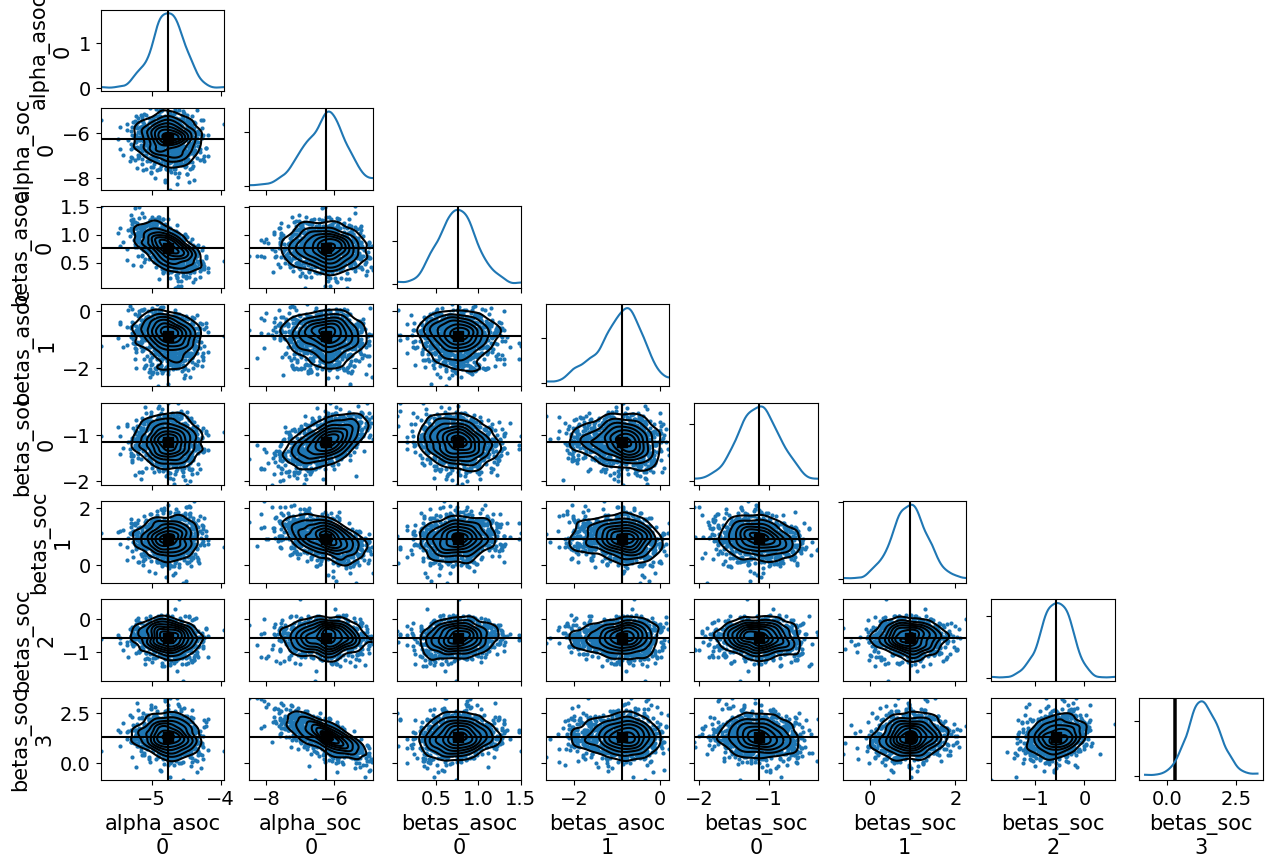

In [21]:
#! Using R data
# Run model to recover parameters 
m = bi()
m.data_on_model=dict(D_asocial = nbda.T_asocial, D_social = nbda.T_social, network = nbda.network, status = nbda.status)
m.run(modelCES, num_samples=1000, num_warmup=500, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

m.diag_pair(figsize = (15, 10))

In [28]:
def priors(nbda, priors = None, CES = True):
    T_social_shape = nbda.T_social.shape[3]
    T_asocial_shape = nbda.T_asocial.shape[2]
    if CES:
        ces_alpha =  m.dist.uniform(0.0001, 0.9999, name = 'ces_alpha')
    if T_social_shape > 1: # Covariates have been provided for social formula
        # Priors for social effect covariates
        alpha_soc = m.dist.normal(0, 2, shape = (1,), sample=False, name='social_learning')
        betas_soc = []
        for a in range(T_social_shape-1):
            beta_soc = m.dist.normal(0, 2, shape = (1,), sample=False, name=f"Beta_social_{nbda.T_social_names[a+1]}")
            betas_soc.append(beta_soc)
        betas_soc  = jnp.concatenate(betas_soc, -1)
        soc = jnp.concatenate((alpha_soc, betas_soc), axis = -1)
    else:
        soc = m.dist.normal(0, 2, shape = (1,), sample=False, name='social_learning')
    if T_asocial_shape > 1: # Covariates have been provided for asocial formula
        # Priors for asocial effect covariates
        alpha_asoc = m.dist.normal(0, 2,  shape = (1,), sample=False, name='asocial_learning')
        
        betas_asoc = []
        for a in range(T_asocial_shape-1):
            beta_asoc = m.dist.normal(0, 2, shape = (1,), sample=False, name=f"Beta_asocial_{nbda.T_asocial_names[a+1]}")
            betas_asoc.append(beta_asoc)
        betas_asoc  = jnp.concatenate(betas_asoc, -1)
        asoc = jnp.concatenate((alpha_asoc, betas_asoc), axis = -1)
    else:
        asoc = m.dist.normal(0, 2, shape = (1,), sample=False, name='asocial_learning')

    if CES :
        return soc, asoc, ces_alpha
    else:
        return soc, asoc
    
def model2(nbda, CES = True):
    status = nbda.status
    network = nbda.network
    D_asocial = nbda.T_asocial
    D_social = nbda.T_social

    N = status.shape[0] # Number of individuals
    T = status.shape[1] # Number of time steps
    P = status.shape[2] # Number of processes

    lk = jnp.zeros((N,T, P))
    
    soc, asoc, ces_alpha = priors(nbda, CES)

    # Asocial learning -----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], asoc, axes=(-1, 0))    
    theta = m.link.inv_logit(R_asocial)
    lk = lk.at[:,0, 0].set(theta)

    for t in range(1,T):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], soc, axes=(-1, 0))
        phi = m.link.inv_logit(R_social)
        attention_weigthed_network = ces(phi*network[:,:,t,0], phi*network[:,:,t,0].T, ces_alpha)
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc, axes=(-1, 0))
        theta = m.link.inv_logit(R_asocial)
        # Informed update at t!= 0-----------------------
        lk = lk.at[:,t, 0].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))

    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        #m.binomial(probs=lk, obs=status[:,:,0])
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status)

In [29]:
m = bi()
m.data_on_model=dict(nbda = nbda)
m.run(model2, num_samples=500, num_warmup=500, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)


jax.local_device_count 1


sample: 100%|██████████| 1000/1000 [09:55<00:00,  1.68it/s, 15 steps of size 1.66e-01. acc. prob=0.94]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


Estimated parameters
                               mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
Beta_asocial_covNF_i_Gold[0]   0.79  0.25      0.35       1.15       0.02   
Beta_asocial_covNF_i_Mass[0]  -1.52  0.95     -2.89      -0.23       0.08   
Beta_social_covDF_Dominant[0]  0.21  0.34     -0.27       0.77       0.02   
Beta_social_covDF_Kinship[0]   1.70  0.51      0.88       2.44       0.03   
Beta_social_covNF_i_Gold[0]   -1.16  0.33     -1.56      -0.54       0.02   
Beta_social_covNF_i_Mass[0]    1.22  0.42      0.60       1.89       0.02   
Beta_social_covNF_j_Gold[0]   -0.65  0.36     -1.19      -0.12       0.02   
Beta_social_covNF_j_Mass[0]    1.61  0.63      0.77       2.75       0.03   
asocial_learning[0]           -4.74  0.24     -5.13      -4.39       0.02   
ces_alpha                      0.23  0.13      0.02       0.43       0.01   
social_learning[0]            -6.62  0.69     -7.56      -5.60       0.05   

                               mcse_sd  ess_bulk  ess_

## Testing parmeter recovery

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
colormap = cm.viridis  # Define the colormap
# Normalize colormap
def plot_res(ax1, df, param = 'social_learning', colors = None, norm = None, text = False):
    if colors is None and norm is None:
        norm = mcolors.Normalize(vmin =  df[df['Unnamed: 0'] == param].sim_value.min().item(), 
                                vmax= df[df['Unnamed: 0'] == param].sim_value.max().item())
        colors = colormap(norm(df[df['Unnamed: 0'] == param].sim_value.values))


    tmp = df[df['Unnamed: 0'] == param]
    for i in range(len(tmp)):
        y = tmp['mean'].values[i]
        x = tmp['sim_value'].values[i]
        ax1.errorbar(
            y = y, x = x,
            yerr = np.vstack([abs(tmp['mean'].values[i] - tmp['hdi_5.5%'].values[i]), abs(tmp['hdi_94.5%'].values[i]-tmp['mean'].values[i]) ]),
            fmt='none', ecolor=colors[i], capsize=5, alpha = 0.5
        )
        if text:
            ax1.text(x, y, f'{y:.2f}/{x:.2f}', fontsize=10, ha='center', va='bottom', alpha = 0.6)
    
    sc = ax1.scatter(y = tmp['mean'].values, x = tmp['sim_value'].values, c=colors, cmap='viridis', norm=norm)

    
    ax1.set_xlabel('Simulated ' + param)
    ax1.set_ylabel('Estimation')

    ## Force same axis range on x and y within subplot
    all_values = np.concatenate([tmp['hdi_5.5%'].values, tmp['hdi_94.5%'].values])
    lower = all_values.min() - 0.5
    upper = all_values.max() + 0.5
    ax1.set_xlim(lower, upper)
    ax1.set_ylim(lower, upper)
    ax1.set_aspect('equal', adjustable='box')  #  for square plot
    ticks = np.linspace(lower, upper, num=6)
    ticks = ticks.astype(int)
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)

    ax1.plot([lower, upper], [lower, upper], linestyle='--', color='gray', linewidth=1)


    return ax1

colormap = cm.viridis  # Define the colormap

0    asocial_learning
1     social_learning
2           ces_alpha
3    asocial_learning
4     social_learning
Name: Unnamed: 0, dtype: object


/tmp/ipykernel_179813/4028391936.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  sc = ax1.scatter(y = tmp['mean'].values, x = tmp['sim_value'].values, c=colors, cmap='viridis', norm=norm)


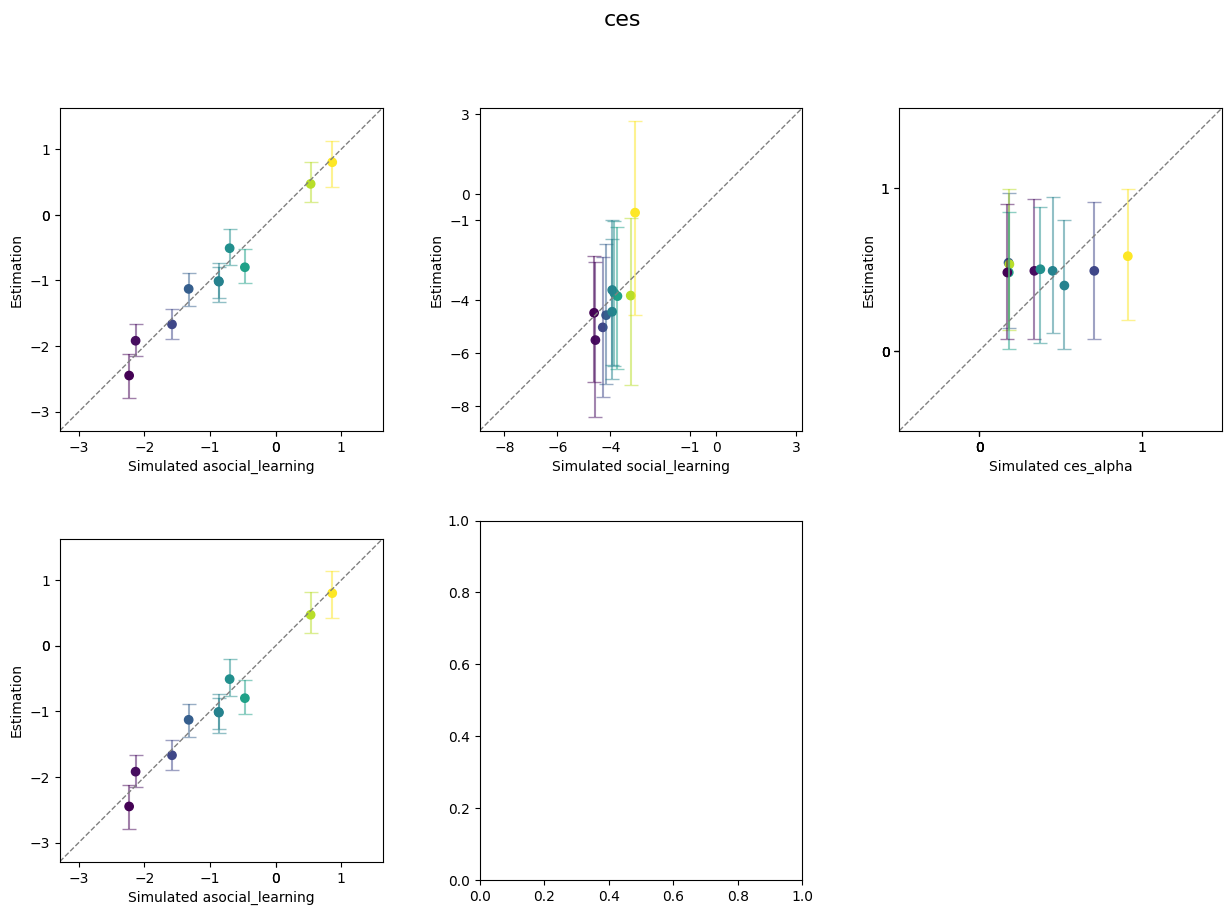

In [ ]:
# Load data
df = pd.read_csv('ces.csv')
df.head()
params = df['Unnamed: 0'][0:5]
print(params)

norm = mcolors.Normalize(vmin =  df[df['Unnamed: 0'] == 'asocial_learning'].sim_value.min().item(), 
                        vmax= df[df['Unnamed: 0'] == 'asocial_learning'].sim_value.max().item())
colors = colormap(norm(df[df['Unnamed: 0'] == 'asocial_learning'].sim_value.values))

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
ax1=plot_res(ax1, df, params[0], colors, norm, text = False)
ax2=plot_res(ax2, df, params[1], colors, norm, text = False)
ax3=plot_res(ax3, df, params[2], colors, norm, text = False)
ax4=plot_res(ax4, df, params[3], colors, norm, text = False)
#ax5=plot_res(ax5, df, params[4], colors, norm, text = False)
ax6.axis('off')
fig.suptitle("ces", fontsize=16)
fig.subplots_adjust(top=0.9, wspace=0.3)  
plt.show()

# A Joint Model of SRM+BLOCK and NBDA

## When and Why Original NBDA Can Fail

*   **When $S_{\mu}$ (sender effect for a covariate $\mu$) is negative or small**  

NBDA, particularly for directed networks, primarily accounts for *emitted* links when assessing social transmission. If $S_{\mu}$ is negative (or very small), individuals with high values for the covariate $\mu$ will emit fewer links. This sparsity of relevant emitted links can reduce the accuracy of NBDA in estimating the influence of $\mu$ on transmission. For example, high-ranking individuals might primarily *receive* grooming (i.e., emit few grooming ties) but their rank could still positively influence social transmission (e.g., they are more likely to learn from others). In such cases, a CES model might offer a solution as CES models can account for link directionality.
  
*Challenging Scenario for NBDA/CES:* Thus a specific simulation scenario where NBDA (and potentially CES) might struggle would involve a covariate with a large negative $S_{\mu}$ (few emitted links by those high on the covariate) alongside a large positive $R_{\mu}$ (many received links by those high on the covariate, if the behavior can be learned from being the target of an interaction). If transmission relies on *emitting*, the negative $S_{\mu}$ is problematic.

*   **When network is affected by exposure bias**  
  
If covariate that affect link emission probability also affect exposure bias (e.g., one observed less those individuals but the covariate affect positively link emission probability, real example?).

When sampling effort is low, uncertainty and accuracy of NBDA model become more important, by accounting for SRM model with NBDA model accuracy become better.

## Why a Joint Model of SRM and NBDA is Proposed:

*   **Explaining Estimation Difficulties:** If $S_{\mu}$ is negative (or small) *and* $R_{\mu}$ (receiver effect) is also small or negative for a given covariate, even a CES model might not accurately capture the transmission dynamics due to overall link sparsity related to that covariate. The proposed joint model wouldn't solve the sparsity issue for transmission estimation either. However, it would be better at **explaining why** the estimation is problematic. By recovering SRM parameters (like $S_{\mu}$ or $R_{\mu}$), the model would highlight the low probability of observing links (emitted or received) associated with that covariate. This serves as a crucial warning to the user that the NBDA-derived estimate of that covariate's effect on social transmission is likely unreliable due to insufficient network data.

*   **Disentangling Direct and Indirect Effects:** 
Even without strong biases in the data-generating process (like the $S_{\mu}$ scenario), the joint model offers a significant advantage: it can help disentangle the **direct and indirect effects** of a covariate on social transmission.
    *   The **SRM component** would model the effect of the covariate on the underlying probability of tie formation (i.e., how the covariate shapes the social network structure). This is an *indirect* pathway for influencing transmission.
    *   The **NBDA component** would then model the effect of the covariate on the probability of acquiring the behavior, *given that a tie exists* and social learning occurs across it. This is a more *direct* pathway related to the efficacy of transmission over existing links.

By consequences, if the covariate have a positive effect on the probability of tie formation, 


## Covariate affecting sampling biases

[5 5 4 6 6 5 5 3 5 5 5 5 7 6 4 6 6 8 4 3 4 5 7 5 5 8 4 7 5 7 6 1 8 4 6 3 4 6 6 5 8 6 6 6 5 6 8 6 8 4]


Array([5, 5, 4, 6, 6, 5, 5, 3, 5, 5, 5, 5, 7, 6, 4, 6, 6, 8, 4, 3, 4, 5, 7, 5, 5, 8, 4, 7, 5, 7, 6, 1, 8, 4, 6, 3, 4, 6, 6, 5, 8, 6, 6, 6, 5, 6, 8, 6, 8, 4], dtype=int64)

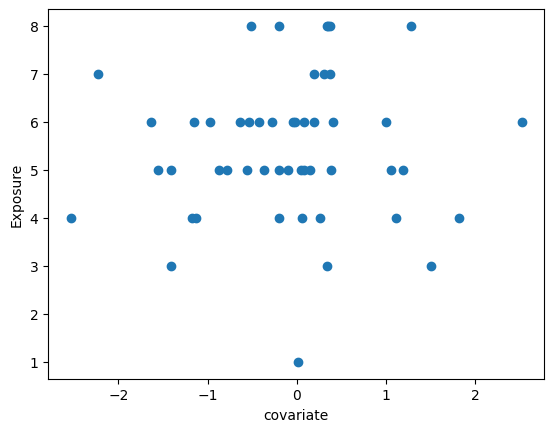

In [90]:
N = 50
def exposure_bias(cov = m.dist.normal(0,1,sample = True, shape = (N,)),
        exposure_alpha = 0.001, exposure_beta= 0.001,
        exposure_sigma = 0.001, exposure_max = 50,
        print_exposure = True):

    exposure = m.dist.normal(exposure_alpha + exposure_beta*cov ,exposure_sigma, sample = True )
    true_exposure = m.dist.binomial(total_count=exposure_max, probs = m.link.inv_logit(exposure),  sample = True) 
    print(true_exposure)
    if print_exposure:
        plt.scatter(cov,true_exposure)
        plt.xlabel('covariate')
        plt.ylabel('Exposure')
    return true_exposure
exposure_bias(exposure_alpha = 0.0, exposure_beta= -0.,
            exposure_sigma = 0.0, exposure_max = 10)

In [15]:
def exposure_vector_to_exposure_matrice(exposure_vector):
    mat =  jnp.tile(exposure_vector,(exposure_vector.shape[0],1)) + jnp.tile(exposure_vector,(exposure_vector.shape[0],1)).T
    mat =  mat.at[jnp.diag_indices(exposure_vector.shape[0])].set(0)
    return mat

In [457]:
N=50
times=100
b_ij_mean1 = -2
b_ij_sd1 = 0.2
b_ii_mean1 = 0.1
b_ii_sd1 = 0.01
b_ij_mean = 0.2
b_ij_sd = 0.1
b_ii_mean = 2
b_ii_sd = 0.5
s_mu= 0.4
s_sd = 0.1
r_mu= 0.1
r_sd= 0.01
dr_mu = 0.6
dr_sd = 0.1
Ngrp = 3
print_network = False
add_covNF = True
add_covNV = True
exposure_alpha = 0.001
exposure_beta= 0.001
exposure_sigma = 0.001
exposure_max = 10
print_exposure = False
# Covariates--------------------------------------
covNF = scale(m.dist.normal(0,1, sample = True, shape = (1,N), seed = random_seed()))
covNV = sim_covNV(N, times, 0.25, 0.30, 0.15)
covDF = sim_covDF(N)
# Network-----------------------------------------------------------
## Block ---------------------------------------
blocks = sim_grp(N, Ngrp=2,gByGrp=jnp.array([1,Ngrp]))
block0=blocks[0]
block1=blocks[1]
B0 = m.net.block_model(block0,1, b_ij_mean = b_ij_mean1, b_ij_sd = b_ij_sd1, b_ii_mean = b_ii_mean1, b_ii_sd = b_ii_sd1,sample=True)
B1 = m.net.block_model(block1,Ngrp, b_ij_mean = b_ij_mean, b_ij_sd = b_ij_sd, b_ii_mean = b_ii_mean, b_ii_sd = b_ii_sd,sample=True)
### SR shape =  N individuals---------------------------------------
if add_covNF == True and add_covNV == True:
    focal_individual_predictors = covNF
    focal_individual_predictors = jnp.concat([covNF, jnp.expand_dims(covNV[:,0],0)])
elif add_covNF == True and add_covNV == False:
    focal_individual_predictors = covNF
elif add_covNF == False and add_covNV == True:
    focal_individual_predictors = jnp.expand_dims(covNV[:,0],0)

target_individual_predictors=focal_individual_predictors
sr =  m.net.sender_receiver(focal_individual_predictors,target_individual_predictors,
                             s_mu= s_mu, s_sd = s_sd, r_mu= r_mu, r_sd= r_sd,
                             sample=True)

## Dyadic shape = N dyads-------------------------------------- 
dyadic_predictors = m.net.mat_to_edgl(covDF)
dr = m.net.dyadic_effect(dyadic_predictors=dyadic_predictors,dr_mu = dr_mu, dr_sd = dr_sd, shape=(N,), sample=True)

# Biase of observations based on individual covariates
exposure = exposure_bias(
    cov = covNF,
    exposure_alpha = exposure_alpha, exposure_beta = exposure_beta,  exposure_sigma = exposure_sigma, exposure_max = exposure_max,
    print = print_exposure
)

network_no_bias = m.net.edgl_to_mat(m.dist.binomial(total_count = exposure_max, logits = B0 + B1 + sr + dr, sample=True ), N)
network_no_bias = network_no_bias/exposure_max

exposure_mat = exposure_vector_to_exposure_matrice(exposure)
exposure_edgl = m.net.mat_to_edgl(exposure_mat)
network_bias = m.net.edgl_to_mat(m.dist.binomial(total_count = exposure_edgl, logits = B0 + B1 + sr + dr, sample=True ), N)
network_biasold = network_bias
network_bias = network_bias/exposure_mat
network_bias = network_bias.at[jnp.diag_indices_from(network_bias)].set(0)
print(jnp.any(jnp.isnan(network_bias)))

False


In [ ]:
def create_covariates2(N=50, times=00,
b_ij_mean1 = -2, b_ij_sd1 = 0.2, b_ii_mean1 = 0.1, b_ii_sd1 = 0.01,
b_ij_mean = 0.2, b_ij_sd = 0.1, b_ii_mean = 2, b_ii_sd = 0.5,
s_mu= 0.4, s_sd = 0.1, r_mu= 0.1, r_sd= 0.01,
dr_mu = 0.6, dr_sd = 0.1,
Ngrp = 3, print_network = False, add_covNF = True, add_covNV = True,
exposure_alpha = 0.001, exposure_beta= 0.001,
exposure_sigma = 0.001, exposure_max = 10,
print_exposure = True):
    # Covariates--------------------------------------
    covNF = scale(m.dist.normal(0,1, sample = True, shape = (1,N), seed = random_seed()))
    covNV = sim_covNV(N, times, 0.25, 0.30, 0.15)
    covDF = sim_covDF(N)

    # Network-----------------------------------------------------------
    ## Block ---------------------------------------
    blocks = sim_grp(N, Ngrp=2,gByGrp=jnp.array([1,Ngrp]))
    block0=blocks[0]
    block1=blocks[1]
    B0 = m.net.block_model(block0,1, b_ij_mean = b_ij_mean1, b_ij_sd = b_ij_sd1, b_ii_mean = b_ii_mean1, b_ii_sd = b_ii_sd1,sample=True)
    B1 = m.net.block_model(block1,Ngrp, b_ij_mean = b_ij_mean, b_ij_sd = b_ij_sd, b_ii_mean = b_ii_mean, b_ii_sd = b_ii_sd,sample=True)
    ### SR shape =  N individuals---------------------------------------
    if add_covNF == True and add_covNV == True:
        focal_individual_predictors = covNF
        focal_individual_predictors = jnp.concat([covNF, jnp.expand_dims(covNV[:,0],0)])
    elif add_covNF == True and add_covNV == False:
        focal_individual_predictors = covNF
    elif add_covNF == False and add_covNV == True:
        focal_individual_predictors = jnp.expand_dims(covNV[:,0],0)
    
    target_individual_predictors=focal_individual_predictors
    sr =  m.net.sender_receiver(focal_individual_predictors,target_individual_predictors,
                                 s_mu= s_mu, s_sd = s_sd, r_mu= r_mu, r_sd= r_sd,
                                 sample=True)
    
    ## Dyadic shape = N dyads-------------------------------------- 
    dyadic_predictors = m.net.mat_to_edgl(covDF)
    dr = m.net.dyadic_effect(dyadic_predictors=dyadic_predictors,dr_mu = dr_mu, dr_sd = dr_sd, shape=(N,), sample=True)
    

    # Biase of observations based on individual covariates
    exposure = exposure_bias(
        cov = covNF,
        exposure_alpha = exposure_alpha, exposure_beta = exposure_beta,  exposure_sigma = exposure_sigma, exposure_max = exposure_max,
        print_exposure = print_exposure
    )
    
    network_no_bias = m.net.edgl_to_mat(m.dist.binomial(total_count = exposure_max, logits = B0 + B1 + sr + dr, sample=True ), N)
    network_no_bias = network_no_bias/exposure_max
   
    exposure_mat = exposure_vector_to_exposure_matrice(exposure)
    exposure_edgl = m.net.mat_to_edgl(exposure_mat)
    network_bias = m.net.edgl_to_mat(m.dist.binomial(total_count = exposure_edgl, logits = B0 + B1 + sr + dr, sample=True ), N)
    network_bias_old = network_bias
    network_bias = network_bias/exposure_mat
    network_bias = network_bias.at[jnp.diag_indices_from(network_bias)].set(0)
    
    if jnp.any(jnp.isnan(network_bias)):
        nan_indices = jnp.where(jnp.isnan(network_bias))
        print(network_bias_old[nan_indices])
        print(exposure_mat[nan_indices])
        network_bias = network_bias.at[nan_indices].set(0)
    
    if print_network:
        viz_network(network_no_bias, block1)
        viz_network(network_bias, block1)

    # Covariates-----------------------------------------------------------
    time = jnp.arange(0,times)
    covF = focal_individual_predictors # Fixed covariate
    jnp.tile(covF[0,:], (times, 1)).T.shape

    # Time-varying covariate

    covDV = create_random_network(N, rate=0.3, seed=10)
    covDV = vmap(lambda x: covDV + x)(time).transpose(1,2,0) # Time-varying dyadic covariate
    covDF2 = grp_belonging_to_mat(block1)
    plt.show()
    return {
        'covF': covNF[0,:],
        'covV': covNV,
        'network': network_no_bias,
        'networkBias' : network_bias,
        'covDF': covDF,
        'covDV': covDV,
        'covDF2': block1,
        'exposure': exposure
    }


## Diffusion

jax.local_device_count 32
[[7 6 2 4 4 4 5 3 5 5 5 5 3 4 7 6 6 5 6 7 7 4 7 5 4 2 3 3 6 4 6 9 3 4 5 1 4 5 6 3 6 4 6 5 6 4 6 5 4 6 5 4 5 3 6 5 5 6 6 7 3 3 5 4 3 4 5 8 2 7 6 8 6 5 5 3 4 3 5 7 9 5 7 6 3 6 4 5 4 8 4 4 5 5 6 3 5 4
  5 6]]


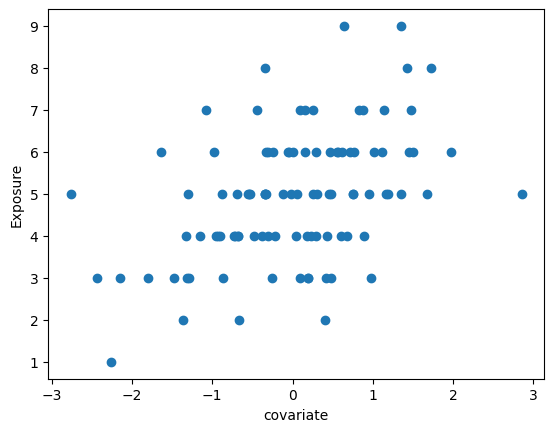

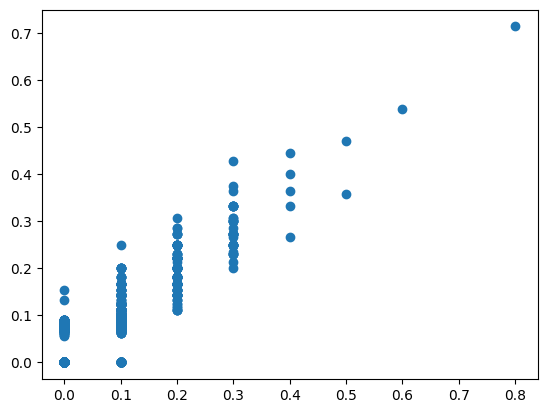

In [103]:
import pandas as pd
m = bi()
N=100 # Number of individuals
times=100 # number of time steps
covariates_data = create_covariates2(N=N, times=times, print_network= False,Ngrp = 3,
                                b_ij_mean1 = 0, b_ij_sd1 = 0.2, b_ii_mean1 = 0.06, b_ii_sd1 = 0.01,
                                b_ij_mean = 0.1, b_ij_sd = 0.05, b_ii_mean = 0.4, b_ii_sd = 0.1,
                                s_mu= .6, s_sd = 0.2, r_mu= 0.6, r_sd= 0.2,
                                dr_mu = .21, dr_sd = 0.1,
                                add_covNF = True, add_covNV = False,
                                exposure_alpha = .0, exposure_beta= .4,
                                exposure_sigma = 0., exposure_max = 10,
                                print_exposure = True
)

alpha_social = jnp.array([1, 0.5, 0.1 ]) 
alpha_asocial =jnp.array([-4, -0.5])

nbda=NBDA(covariates_data['network'], jnp.zeros((N,times)))
nbda.import_covNF(pd.DataFrame(covariates_data['covF']))
nbda.get_cov()
status = diffusion(nbda, alpha_social, alpha_asocial) # Diffusion on non bias network
plt.scatter(y = covariates_data['networkBias'], x = covariates_data['network'])

## Model

In [33]:
@jit
def logit(x):
    return jnp.log(x / (1 - x))

def SRM_NBDA(exposure_mat, nbda, network ):
    status = nbda.status
    T_asocial = nbda.T_asocial
    T_social = nbda.T_social
    N = status.shape[0] # Number of individuals
    T = status.shape[1] # Number of time steps
    P = status.shape[2] # Number of processes

    # latent_network -------------------------------------------------------------
    theta = m.dist.beta(1,1, shape = (N,N), name = 'theta')
    network = m.dist.binomial(total_count = exposure_mat, probs = theta,  name = 'latentnetwork', obs = network)    
    network = network.at[jnp.diag_indices_from(network)].set(0)
    network =  jnp.repeat(network[jnp.newaxis, :, :,jnp.newaxis], T, axis=0).transpose((1,2,0,3))
    
    # NBDA model -------------------------------------------------------------
    lk = jnp.zeros((N,T, P))
    
    # Priors for social effect covariates
    alpha_soc = m.dist.normal(0, 2.5, shape = (1,), sample=False, name='alpha_soc')
    betas_soc = m.dist.normal(0, 1, shape = (T_social.shape[3]-1,), sample=False, name='betas_soc')
    soc = jnp.concatenate((alpha_soc, betas_soc))

    # Priors for asocial effect covariates
    alpha_asoc = m.dist.normal(0, 2.5,  shape = (1,), sample=False, name='alpha_asoc')
    betas_asoc = m.dist.normal(0, 1, shape = (T_asocial.shape[2]-1,), sample=False, name='betas_asoc')
    asoc = jnp.concatenate((alpha_asoc, betas_asoc))
    
    # Asocial learning -----------------------
    R_asocial = jnp.tensordot(T_asocial[:,0,:], asoc, axes=(-1, 0))    
    theta = m.link.inv_logit(R_asocial)
    lk = lk.at[:,0, 0].set(theta)
    
    
    for t in range(1,T):
        ## Social learning-----------------------
        R_social = jnp.tensordot(T_social[:,:,t,:], soc, axes=(-1, 0))
        phi = m.link.inv_logit(R_social)
        attention_weigthed_network = phi*network[:,:,t,0]
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(T_asocial[:,t,:], asoc, axes=(-1, 0))
        theta = m.link.inv_logit(R_asocial)
        # Informed update at t!= 0-----------------------
        lk = lk.at[:,t, 0].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))

    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status)

In [34]:
@jit
def logit(x):
    return jnp.log(x / (1 - x))

def SRM_NBDAFULL(
        result_outcomes, 
        dyadic_predictors, focal_individual_predictors, target_individual_predictors, 
        Any, block,
        exposure_mat,
        D_asocial, D_social, status = None
        ):
    
    N = status.shape[0] # Number of individuals
    T = status.shape[1] # Number of time steps
    P = status.shape[2] # Number of processes

    # SRM + Block model -------------------------------------------------------------
    # Block ---------------------------------------
    B_any = m.net.block_model(Any,1)
    B_block = m.net.block_model(block,5)

    ## SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(focal_individual_predictors,target_individual_predictors)

    # Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(dyadic_predictors)

    edgl = m.dist.binomial(total_count = m.net.mat_to_edgl(exposure_mat), logits = B_any + B_block + sr + dr, obs = result_outcomes, name= 'latent network' )
    network = m.net.edgl_to_mat(edgl,N)
    network = network/exposure_mat
    network = network.at[jnp.diag_indices_from(network)].set(0)
    network = jnp.nan_to_num(network, nan=0)
    
    network =  jnp.repeat(network[jnp.newaxis, :, :,jnp.newaxis], T, axis=0).transpose((1,2,0,3))
    # NBDA model -------------------------------------------------------------
    lk = jnp.zeros((N,T, P))
    
    # Priors for social effect covariates
    alpha_soc = m.dist.normal(0, 2.5, shape = (1,), sample=False, name='alpha_soc')
    betas_soc = m.dist.normal(0, 1, shape = (D_social.shape[3]-1,), sample=False, name='betas_soc')
    soc = jnp.concatenate((alpha_soc, betas_soc))

    # Priors for asocial effect covariates
    alpha_asoc = m.dist.normal(0, 2.5,  shape = (1,), sample=False, name='alpha_asoc')
    betas_asoc = m.dist.normal(0, 1, shape = (D_asocial.shape[2]-1,), sample=False, name='betas_asoc')
    asoc = jnp.concatenate((alpha_asoc, betas_asoc))

    # Asocial learning -----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], asoc, axes=(-1, 0))    
    theta = m.link.inv_logit(R_asocial)
    lk = lk.at[:,0, 0].set(theta)

    for t in range(1,T):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], soc, axes=(-1, 0))
        phi = m.link.inv_logit(R_social)
        attention_weigthed_network = phi*network[:,:,t,0]
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc, axes=(-1, 0))
        theta = m.link.inv_logit(R_asocial)
        # Informed update at t!= 0-----------------------
        lk = lk.at[:,t, 0].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))

    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status)

## Parameter recovery

### Original Model without biased network

In [92]:
nbda=NBDA(covariates_data['network'], status)
nbda.import_covNF(pd.DataFrame(covariates_data['covF']))
nbda.get_cov()
m = bi()
m.data_on_model=dict(D_asocial = nbda.T_asocial, D_social = nbda.T_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
m.summary()
#alpha_social = jnp.array([1, 0.5, 0.1 ]) 
#alpha_asocial =jnp.array([-4, -0.5])

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:25<00:00, 77.75it/s, 15 steps of size 3.63e-01. acc. prob=0.84] 


,mean,sd,hdi_5.5%,hdi_94.5%
alpha_asoc[0],-4.11,0.47,-4.88,-3.43
alpha_soc[0],3.69,2.54,0.24,7.30
betas_asoc[0],-0.58,0.40,-1.22,0.05
betas_soc[0],-0.08,0.84,-1.39,1.26
betas_soc[1],-0.08,1.04,-1.83,1.47


### NBDA with biased network (should fail to find the correct parameters)

In [93]:
nbda2=NBDA(covariates_data['networkBias'], status)
nbda2.import_covNF(pd.DataFrame(covariates_data['covF']))
nbda2.get_cov()
m = bi()
m.data_on_model=dict(D_asocial = nbda2.T_asocial, D_social = nbda2.T_social, network = nbda2.network, status = nbda2.status)
m.run(model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
m.summary()
#alpha_social = jnp.array([1, 0.5, 0.1 ]) 
#alpha_asocial =jnp.array([-4, -0.5])

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:26<00:00, 75.24it/s, 15 steps of size 3.54e-01. acc. prob=0.84] 


,mean,sd,hdi_5.5%,hdi_94.5%
alpha_asoc[0],-4.05,0.50,-4.71,-3.17
alpha_soc[0],3.21,2.33,0.08,6.51
betas_asoc[0],-0.40,0.43,-1.07,0.29
betas_soc[0],-0.24,0.84,-1.54,1.11
betas_soc[1],-0.19,1.01,-1.94,1.27


### SRM + NBDA without biased network (results should be the same as previous results)

In [94]:
nbda3=NBDA(covariates_data['networkBias'], status)
nbda3.import_covNF(pd.DataFrame(covariates_data['covF']))
nbda3.get_cov()
m = bi()
m.data_on_model=dict(
    exposure_mat = exposure_vector_to_exposure_matrice(covariates_data['exposure'][0,:]), 
    nbda = nbda3, 
    network = covariates_data['networkBias']
)
m.run(SRM_NBDA, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
m.summary()
#alpha_social = jnp.array([1, 0.5, 0.1 ]) 
#alpha_asocial =jnp.array([-4, -0.5])

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:31<00:00, 21.85it/s, 31 steps of size 1.21e-01. acc. prob=0.89]


,mean,sd,hdi_5.5%,hdi_94.5%
alpha_asoc[0],-3.83,0.42,-4.58,-3.26
alpha_soc[0],1.81,1.22,-0.08,3.53
betas_asoc[0],-0.41,0.38,-1.00,0.18
betas_soc[0],-0.30,0.74,-1.54,0.81
betas_soc[1],-0.26,0.97,-1.89,1.25
...,...,...,...,...
"theta[49, 45]",0.02,0.02,0.00,0.04
"theta[49, 46]",0.02,0.02,0.00,0.04
"theta[49, 47]",0.02,0.02,0.00,0.05
"theta[49, 48]",0.02,0.02,0.00,0.04


In [104]:
m = bi()
m.data_on_model = dict(
    Any = jnp.zeros_like(covariates_data['covDF2']), # array of one of shape(1,N)
    block = covariates_data['covDF2']-1, # array of shape(1,N) representing node group belonging
    result_outcomes = m.net.mat_to_edgl(covariates_data['networkBias']), 
    dyadic_predictors = m.net.mat_to_edgl(covariates_data['covDF']),
    focal_individual_predictors =  covariates_data['covF'].reshape(1,covariates_data['covF'].shape[0]),
    target_individual_predictors =  covariates_data['covF'].reshape(1,covariates_data['covF'].shape[0]),
    exposure_mat = exposure_vector_to_exposure_matrice(covariates_data['exposure'][0,:]),
    D_asocial = nbda.T_asocial, D_social = nbda.T_social, status = nbda.status
)

m.run(SRM_NBDAFULL) 
m.summary()
#alpha_social = jnp.array([1, 0.5, 0.1 ]) 
#alpha_asocial =jnp.array([-4, -0.5])

jax.local_device_count 32


warmup:   1%|          | 9/1000 [00:25<47:02,  2.85s/it, 1023 steps of size 9.56e-03. acc. prob=0.56]


KeyboardInterrupt: 

In [100]:
m.tab_summary[m.tab_summary.index.str.contains('betas_', case=False)]

,mean,sd,hdi_5.5%,hdi_94.5%
betas_asoc[0],0.00,0.61,-0.90,1.04
betas_soc[0],0.01,0.99,-1.69,1.40
betas_soc[1],0.00,1.06,-1.60,1.78


### SIMS join model

In [ ]:
# Build data -------------------------------------------------------------
m = bi()
N=50 # Number of individuals
times=100 # number of time steps
covariates_data = create_covariates2(N=N, times=times, print_network= False,Ngrp = 3,
                                b_ij_mean1 = 0, b_ij_sd1 = 0.2, b_ii_mean1 = 0.06, b_ii_sd1 = 0.01,
                                b_ij_mean = 0.1, b_ij_sd = 0.05, b_ii_mean = 0.4, b_ii_sd = 0.1,
                                s_mu= -.6, s_sd = 0.2, r_mu= 0.6, r_sd= 0.2,
                                dr_mu = .21, dr_sd = 0.1,
                                add_covNF = True, add_covNV = False,
                                exposure_alpha = .0, exposure_beta= -.04,
                                exposure_sigma = 0.1, exposure_max = 50,
                                print_exposure = False
)

alpha_social = jnp.array([1, 0.5, 0.1 ]) 
alpha_asocial =jnp.array([-4, -0.5])

nbda=NBDA(covariates_data['network'], jnp.zeros((N,times)))
nbda.import_covNF(pd.DataFrame(covariates_data['covF']))
nbda.get_cov()
status = diffusion(nbda, alpha_social, alpha_asocial) # Diffusion on non bias network
#plt.scatter(y = covariates_data['networkBias'], x = covariates_data['network'])


# Run models -------------------------------------------------------------
# Model with NBDA and true network ---------------------------------------
print("True network")
nbda=NBDA(covariates_data['network'], status)
nbda.import_covNF(pd.DataFrame(covariates_data['covF']))
nbda.get_cov()
m = bi()
m.data_on_model=dict(D_asocial = nbda.T_asocial, D_social = nbda.T_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary1 = m.summary()

summary1 = summary1.rename(index={
    summary.index[0]: 'asocial_learning',
    summary.index[1]: 'social_learning',
    summary.index[2]: 'Beta_asocial_covNF_i_0',
    summary.index[3]: 'Beta_social_covNF_i_0',
    summary.index[4]: 'Beta_social_covNF_j_0',

})

# Model with NBDA and biased network -------------------------------------
print("Biased network")
nbda2=NBDA(covariates_data['networkBias'], status)
nbda2.import_covNF(pd.DataFrame(covariates_data['covF']))
nbda2.get_cov()
m = bi()
m.data_on_model=dict(D_asocial = nbda2.T_asocial, D_social = nbda2.T_social, network = nbda2.network, status = nbda2.status)
m.run(model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary2 = m.summary()

summary2 = summary2.rename(index={
    summary.index[0]: 'asocial_learning',
    summary.index[1]: 'social_learning',
    summary.index[2]: 'Beta_asocial_covNF_i_0',
    summary.index[3]: 'Beta_social_covNF_i_0',
    summary.index[4]: 'Beta_social_covNF_j_0',

})

# Model with NBDA and simple SRM -----------------------------------------
print("Simple SRM")
nbda3=NBDA(covariates_data['networkBias'], status)
nbda3.import_covNF(pd.DataFrame(covariates_data['covF']))
nbda3.get_cov()
m = bi()
m.data_on_model=dict(
    exposure_mat = exposure_vector_to_exposure_matrice(covariates_data['exposure'][0,:]), 
    nbda = nbda3, 
    network = covariates_data['networkBias']
)
m.run(SRM_NBDA, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary3 = m.summary()

new_first_5_names = ["asocial_learning", "social_learning", "Beta_asocial_covNF_i_0", "Beta_social_covNF_i_0", "Beta_social_covNF_j_0"]
current_index_list = list(summary3.index)
for i in range(5):
    current_index_list[i] = new_first_5_names[i]
summary3.index = current_index_list
summary3

## Simulation

In [ ]:

def single_estimation(N = 200, times = 100, 
                      alpha_social = jnp.array([1, 0, 0, 0, 0 ]) , alpha_asocial = jnp.array([-5, -5, -5]),
                      s_mu = -0.4,
                      exposure_beta = -0.4, exposure_max = 50,
                      print_network= False, 
                      Nsim = 0, file = 'test.csv', header = True, mode = 'w', old = False):
    
    # Build data -------------------------------------------------------------
    m = bi()
    covariates_data = create_covariates2(N=N, times=times, print_network= False,Ngrp = 3,
                                    b_ij_mean1 = 0, b_ij_sd1 = 0.2, b_ii_mean1 = 0.06, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.1, b_ij_sd = 0.05, b_ii_mean = 0.4, b_ii_sd = 0.1,
                                    s_mu= s_mu, s_sd = 0.2, r_mu= 0.6, r_sd= 0.2,
                                    dr_mu = .21, dr_sd = 0.1,
                                    add_covNF = True, add_covNV = False,
                                    exposure_alpha = .0, exposure_beta= exposure_beta,
                                    exposure_sigma = 0.1, exposure_max = exposure_max,
                                    print_exposure = False
    )


    nbda=NBDA(covariates_data['network'], jnp.zeros((N,times)))
    nbda.import_covNF(pd.DataFrame(covariates_data['covF']))
    nbda.get_cov()
    status = diffusion(nbda, alpha_social, alpha_asocial) # Diffusion on non bias network
    #plt.scatter(y = covariates_data['networkBias'], x = covariates_data['network'])


    # Run models -------------------------------------------------------------
    # Model with NBDA and true network ---------------------------------------
    print("True network")
    nbda=NBDA(covariates_data['network'], status)
    nbda.import_covNF(pd.DataFrame(covariates_data['covF']))
    nbda.get_cov()
    m = bi()
    m.data_on_model=dict(D_asocial = nbda.T_asocial, D_social = nbda.T_social, network = nbda.network, status = nbda.status)
    m.run(model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
    summary1 = m.summary()

    summary1 = summary1.rename(index={
        summary1.index[0]: 'asocial_learning',
        summary1.index[1]: 'social_learning',
        summary1.index[2]: 'Beta_asocial_covNF_i_0',
        summary1.index[3]: 'Beta_social_covNF_i_0',
        summary1.index[4]: 'Beta_social_covNF_j_0',

    })
    summary1['type'] = 'True network'

    # Model with NBDA and biased network -------------------------------------
    print("Biased network")
    nbda2=NBDA(covariates_data['networkBias'], status)
    nbda2.import_covNF(pd.DataFrame(covariates_data['covF']))
    nbda2.get_cov()
    m = bi()
    m.data_on_model=dict(D_asocial = nbda2.T_asocial, D_social = nbda2.T_social, network = nbda2.network, status = nbda2.status)
    m.run(model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
    summary2 = m.summary()

    summary2 = summary2.rename(index={
        summary2.index[0]: 'asocial_learning',
        summary2.index[1]: 'social_learning',
        summary2.index[2]: 'Beta_asocial_covNF_i_0',
        summary2.index[3]: 'Beta_social_covNF_i_0',
        summary2.index[4]: 'Beta_social_covNF_j_0',
    })
    summary2['type'] = 'Biased network'

    # Model with NBDA and simple SRM -----------------------------------------
    print("Simple SRM")
    nbda3=NBDA(covariates_data['networkBias'], status)
    nbda3.import_covNF(pd.DataFrame(covariates_data['covF']))
    nbda3.get_cov()
    m = bi()
    m.data_on_model=dict(
        exposure_mat = exposure_vector_to_exposure_matrice(covariates_data['exposure'][0,:]), 
        nbda = nbda3, 
        network = covariates_data['networkBias']
    )
    m.run(SRM_NBDA, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
    summary3 = m.summary()
    summary3['type'] = 'SRM'

    new_first_5_names = ["asocial_learning", "social_learning", "Beta_asocial_covNF_i_0", "Beta_social_covNF_i_0", "Beta_social_covNF_j_0"]
    current_index_list = list(summary3.index)
    for i in range(5):
        current_index_list[i] = new_first_5_names[i]
    summary3.index = current_index_list
    summary = pd.concat([summary1, summary2, summary3])
    summary['Nsim'] = Nsim
    summary['s_mu'] = s_mu
    summary['exposure_beta'] = exposure_beta
    summary['exposure_max'] = exposure_max


    sims = dict(
        asocial_learning = alpha_asocial[0],
        Beta_asocial_covNF_i_0 = alpha_asocial[1],
        social_learning = alpha_social[0],
        Beta_social_covNF_i_0 = alpha_social[1],
        Beta_social_covNF_j_0 = alpha_social[2],
    )
    summary['sim_value'] = summary.index.map(sims)
    summary.to_csv(file, header=header, mode = mode)

In [115]:
import gc
def sim_estimations(asoc, soc, s_mu, exposure_beta, exposure_max,
                    file = 'covNF_alone.csv',
                    print_network = False, print_status = False, old = False):

    for i in range(asoc.shape[0]):
        print("Simulation ", str(i+1), " on ", str(asoc.shape[0]), '-------------------------------')
        if i == 0:
            header = True
            mode = 'w'
        else:
            header = False
            mode = 'a'
        N = int(m.dist.uniform(50, 200, sample= True, seed = random2.randint(0,10000)).item())
        times = int(m.dist.uniform(50, 200, sample= True, seed = random2.randint(0,10000)+1).item())
        
        single_estimation(N = N, times = times, alpha_social = soc[i,:] , alpha_asocial = asoc[i,:],
                         s_mu = s_mu[i],
                         exposure_beta = exposure_beta[i], exposure_max = int(exposure_max[i].item()),
                         print_network= print_network,
                         Nsim = i, file = file, header = header, mode = mode, old = old)

        gc.collect()
               

In [ ]:
Nsim = 100
alpha_asocial =  m.dist.uniform(-5,-3, sample = True, shape = (Nsim,), seed = 1)
beta_asocial_covNF =  m.dist.uniform(-1,1, sample = True, shape = (Nsim,), seed = 110)

alpha_social =  m.dist.uniform(-3,1, sample = True, shape = (Nsim,), seed = 0)
beta_socialCOVNF_i =  m.dist.uniform(-1,1, sample = True, shape = (Nsim,), seed = 1)
beta_socialCOVNF_j =  m.dist.uniform(-1,1, sample = True, shape = (Nsim,), seed = 2)

asoc = jnp.stack([alpha_asocial, beta_asocial_covNF]).T
soc = jnp.stack([alpha_social, beta_socialCOVNF_i, beta_socialCOVNF_j]).T

s_mu = m.dist.uniform(-1,1, sample = True, shape = (Nsim,), seed = 0)
exposure_beta = m.dist.uniform(-1,1, sample = True, shape = (Nsim,), seed = 0)
exposure_max = m.dist.uniform(20,80, sample = True, shape = (Nsim,), seed = 0)

sim_estimations(asoc, soc, s_mu, exposure_beta, exposure_max,
                file = 'SRM_sim.csv',
                print_network = True)

Simulation  1  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:35<00:00, 55.59it/s, 15 steps of size 3.82e-01. acc. prob=0.93]


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:34<00:00, 58.40it/s, 7 steps of size 4.06e-01. acc. prob=0.91] 


Simple SRM
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [02:21<00:00, 14.15it/s, 31 steps of size 9.92e-02. acc. prob=0.88]


Simulation  2  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:26<00:00, 23.18it/s, 15 steps of size 3.64e-01. acc. prob=0.85]


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:25<00:00, 23.31it/s, 15 steps of size 3.30e-01. acc. prob=0.89]


Simple SRM
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [05:18<00:00,  6.28it/s, 31 steps of size 9.72e-02. acc. prob=0.87]


Simulation  3  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:01<00:00, 32.75it/s, 7 steps of size 2.93e-01. acc. prob=0.88] 


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:00<00:00, 32.93it/s, 15 steps of size 3.29e-01. acc. prob=0.81]


Simple SRM
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [02:42<00:00, 12.28it/s, 31 steps of size 9.75e-02. acc. prob=0.87]


Simulation  4  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [04:29<00:00,  7.43it/s, 7 steps of size 2.53e-01. acc. prob=0.91] 


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [04:24<00:00,  7.56it/s, 7 steps of size 2.53e-01. acc. prob=0.91] 


Simple SRM
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [21:16<00:00,  1.57it/s, 63 steps of size 7.46e-02. acc. prob=0.84]  


Simulation  5  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:33<00:00, 21.45it/s, 3 steps of size 5.62e-01. acc. prob=0.88] 


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:35<00:00, 20.93it/s, 3 steps of size 4.72e-01. acc. prob=0.90] 


Simple SRM
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [10:18<00:00,  3.23it/s, 31 steps of size 9.26e-02. acc. prob=0.86] 


Simulation  6  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [02:00<00:00, 16.59it/s, 7 steps of size 4.13e-01. acc. prob=0.87] 


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [02:06<00:00, 15.87it/s, 7 steps of size 4.79e-01. acc. prob=0.80] 


Simple SRM
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [12:41<00:00,  2.63it/s, 63 steps of size 8.33e-02. acc. prob=0.84]


Simulation  7  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:49<00:00, 18.31it/s, 7 steps of size 2.95e-01. acc. prob=0.91] 


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:47<00:00, 18.67it/s, 15 steps of size 2.85e-01. acc. prob=0.91]


Simple SRM
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [09:29<00:00,  3.51it/s, 63 steps of size 8.21e-02. acc. prob=0.84]


Simulation  8  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:57<00:00, 34.91it/s, 15 steps of size 3.90e-01. acc. prob=0.87]


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:00<00:00, 33.13it/s, 15 steps of size 3.61e-01. acc. prob=0.91]


Simple SRM
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [03:47<00:00,  8.80it/s, 31 steps of size 1.01e-01. acc. prob=0.85]


Simulation  9  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [02:02<00:00, 16.27it/s, 15 steps of size 2.59e-01. acc. prob=0.90]


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [02:09<00:00, 15.49it/s, 15 steps of size 2.48e-01. acc. prob=0.91]


Simple SRM
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [06:20<00:00,  5.26it/s, 31 steps of size 9.79e-02. acc. prob=0.84]


Simulation  10  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [03:45<00:00,  8.86it/s, 7 steps of size 3.29e-01. acc. prob=0.93] 


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [03:57<00:00,  8.40it/s, 15 steps of size 3.11e-01. acc. prob=0.93]


Simple SRM
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [23:21<00:00,  1.43it/s, 63 steps of size 6.94e-02. acc. prob=0.85] 


Simulation  11  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [02:17<00:00, 14.52it/s, 15 steps of size 2.93e-01. acc. prob=0.90]


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [02:22<00:00, 14.06it/s, 15 steps of size 2.65e-01. acc. prob=0.90]


Simple SRM
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [09:58<00:00,  3.34it/s, 63 steps of size 8.15e-02. acc. prob=0.88]


Simulation  12  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [02:53<00:00, 11.55it/s, 15 steps of size 3.27e-01. acc. prob=0.92]


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [02:37<00:00, 12.71it/s, 11 steps of size 4.53e-01. acc. prob=0.87]


Simple SRM
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [17:47<00:00,  1.87it/s, 63 steps of size 7.84e-02. acc. prob=0.85] 


Simulation  13  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:00<00:00, 33.03it/s, 15 steps of size 2.92e-01. acc. prob=0.91]


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:03<00:00, 31.45it/s, 15 steps of size 2.54e-01. acc. prob=0.91]


Simple SRM
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [02:53<00:00, 11.51it/s, 31 steps of size 1.01e-01. acc. prob=0.88]


Simulation  14  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:02<00:00, 32.26it/s, 15 steps of size 3.04e-01. acc. prob=0.94]


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:57<00:00, 35.03it/s, 3 steps of size 3.80e-01. acc. prob=0.89] 


Simple SRM
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [04:00<00:00,  8.33it/s, 63 steps of size 9.27e-02. acc. prob=0.88] 


Simulation  15  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [03:05<00:00, 10.76it/s, 15 steps of size 3.27e-01. acc. prob=0.92]


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [02:57<00:00, 11.27it/s, 15 steps of size 3.50e-01. acc. prob=0.90]


Simple SRM
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [16:20<00:00,  2.04it/s, 63 steps of size 7.66e-02. acc. prob=0.88]


Simulation  16  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [03:22<00:00,  9.85it/s, 15 steps of size 3.89e-01. acc. prob=0.91]


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [03:23<00:00,  9.81it/s, 7 steps of size 3.55e-01. acc. prob=0.90] 


Simple SRM
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [18:35<00:00,  1.79it/s, 63 steps of size 8.03e-02. acc. prob=0.84] 


Simulation  17  on  100 -------------------------------
jax.local_device_count 32
True network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [03:56<00:00,  8.47it/s, 31 steps of size 2.16e-01. acc. prob=0.94]


Biased network
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [03:43<00:00,  8.96it/s, 15 steps of size 2.50e-01. acc. prob=0.88]


## Plots

In [2]:
# Load data
df = pd.read_csv('SRM_sim.csv')
df.head()


,Unnamed: 0,mean,sd,hdi_5.5%,hdi_94.5%,type,Nsim,s_mu,exposure_beta,exposure_max,sim_value
0,asocial_learning,-4.35,0.33,-4.88,-3.84,True network,0,-0.163086,-0.163086,45,-4.763700
1,social_learning,-1.80,0.39,-2.41,-1.21,True network,0,-0.163086,-0.163086,45,-1.326172
2,Beta_asocial_covNF_i_0,0.02,0.28,-0.44,0.48,True network,0,-0.163086,-0.163086,45,0.019731
3,Beta_social_covNF_i_0,-0.63,0.35,-1.19,-0.09,True network,0,-0.163086,-0.163086,45,-0.763700
4,Beta_social_covNF_j_0,-0.37,0.51,-1.23,0.39,True network,0,-0.163086,-0.163086,45,-0.151957


In [6]:
NBDA_true_net = df[df['type'] == 'True network']
NBDA_Biased_net = df[df['type'] == 'Biased network']
SRM = df[df['type'] == 'SRM']

In [17]:
SRM.exposure_beta.unique()

array([-0.16308578, -0.56740909,  0.93064292,  0.14900107,  0.06445298,
       -0.29018964,  0.76601795,  0.26512078,  0.06760015, -0.61669224,
        0.7083533 , -0.88112142,  0.28678342,  0.98814234,  0.20402923,
       -0.2233677 ])

['asocial_learning' 'social_learning' 'Beta_asocial_covNF_i_0'
 'Beta_social_covNF_i_0' 'Beta_social_covNF_j_0']


/tmp/ipykernel_1059/3908126323.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  sc = ax1.scatter(y = tmp['mean'].values, x = tmp['sim_value'].values, c=colors, cmap='viridis', norm=norm)


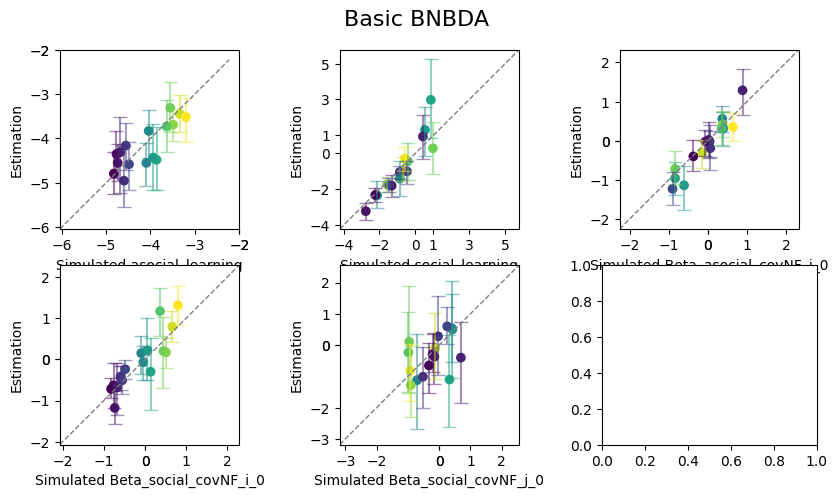

In [13]:
def plot_sims(NBDA_true_net):
    params = NBDA_true_net['Unnamed: 0'].unique()
    print(params)
    colormap = cm.viridis  # Define the colormap
    norm = mcolors.Normalize(vmin =  NBDA_true_net[NBDA_true_net['Unnamed: 0'] == 'asocial_learning'].sim_value.min().item(), 
                            vmax= NBDA_true_net[NBDA_true_net['Unnamed: 0'] == 'asocial_learning'].sim_value.max().item())
    colors = colormap(norm(NBDA_true_net[NBDA_true_net['Unnamed: 0'] == 'asocial_learning'].sim_value.values))

    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 5))
    ax1=plot_res(ax1, NBDA_true_net, params[0], colors, norm, text =False)
    #ax1.set_xlabel(r'Simulated $\hat{\alpha}$', fontsize=14)
    ax2=plot_res(ax2, NBDA_true_net, params[1], colors, norm, text =False)
    #ax2.set_xlabel(r'Simulated $\alpha$', fontsize=14)
    ax3=plot_res(ax3, NBDA_true_net, params[2], colors, norm, text =False)
    #ax3.set_xlabel(r'Simulated $\alpha$', fontsize=14)
    ax4=plot_res(ax4, NBDA_true_net, params[3], colors, norm, text =False)
    #ax4.set_xlabel(r'Simulated $\alpha$', fontsize=14)
    ax5=plot_res(ax5, NBDA_true_net, params[4], colors, norm, text =False)
    #ax5.set_xlabel(r'Simulated $\alpha$', fontsize=14)
    fig.suptitle("Basic BNBDA", fontsize=16)
    fig.subplots_adjust(top=0.9, wspace=0.3)  
    plt.show()
plot_sims(NBDA_true_net)

['asocial_learning' 'social_learning' 'Beta_asocial_covNF_i_0'
 'Beta_social_covNF_i_0' 'Beta_social_covNF_j_0']


/tmp/ipykernel_1059/3908126323.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  sc = ax1.scatter(y = tmp['mean'].values, x = tmp['sim_value'].values, c=colors, cmap='viridis', norm=norm)


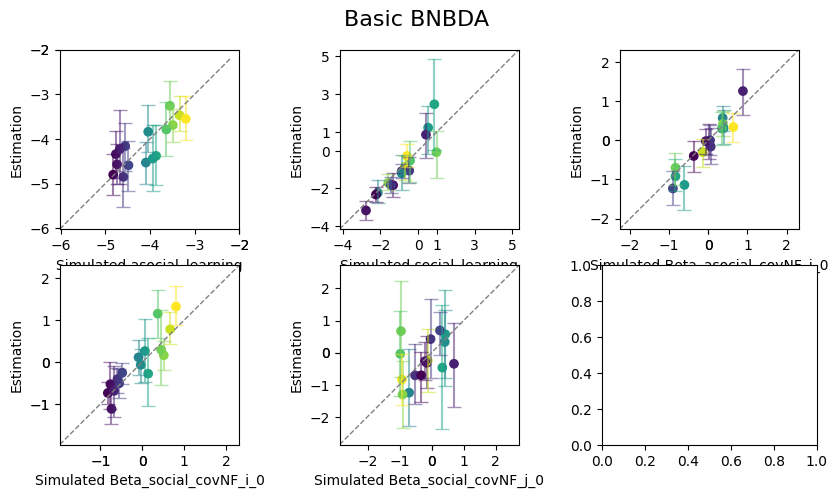

In [14]:
plot_sims(NBDA_Biased_net)

['asocial_learning' 'social_learning' 'Beta_asocial_covNF_i_0' ...
 'theta[195, 193]' 'theta[195, 194]' 'theta[195, 195]']


/tmp/ipykernel_1059/3908126323.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  sc = ax1.scatter(y = tmp['mean'].values, x = tmp['sim_value'].values, c=colors, cmap='viridis', norm=norm)


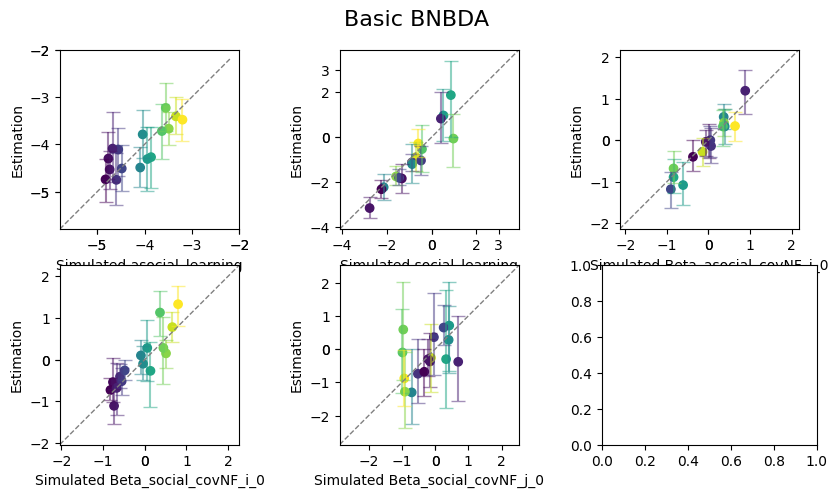

In [15]:
plot_sims(SRM)

# Time varying coefficients

In [ ]:
def coefficients(V, T,
                mu_mu =  0,
                mu_sigma = 1,
                sigma_mu = 1,
                sample = False,
                name = 'betas_soc'):
    """
    Generates time-varying coefficients using hierarchical normal distributions.

    Args:
        V (int): Number of coefficients.
        T (int): Number of time points.
        mu_mu (float, optional): Mean of the Mu_betas distribution. Defaults to 0.0.
        mu_sigma (float, optional): Mean of the Sigma_betas distribution. Defaults to 1.
        sigma_mu (float, optional): Standard deviation of the Mu_betas distribution. Defaults to 1.
        name (str, optional): Name for identification. Defaults to 'betas_soc'.

    Returns:
        Tensor: A tensor of shape (T, V) representing time-varying coefficients.

    Distribution Details:
        - Mu_betas: Normal distribution with mean=mu_mu and std=sigma_mu
        - Sigma_betas: Normal distribution with mean=mu_sigma and std=sigma_sigma
        - betas: Normal distribution with mean=Mu_betas and std=Sigma_betas
    """

    Mu_betas = bee.dist.normal(mu_mu, mu_sigma, shape = (V,), sample=sample, name='Mu_'+name)
    Sigma_betas = bee.dist.exponential(sigma_mu, shape = (V,), sample=sample, name='Sigma_'+name)
    betas = bee.dist.normal(Mu_betas, Sigma_betas, shape = (T,), sample=sample, name='betas_'+name).reshape(T, V)
    return betas

#coefficients(4, 10, sample = True) # 4 variables 10 time points

## Model

In [ ]:
def model(D_asocial, D_social, status, network):
    N = status.shape[0]
    T = status.shape[1]
    lk = jnp.zeros((N,T))

    # Priors for social effect covariates
    soc = coefficients(1, T, mu_mu =  0, mu_sigma = 5, sigma_mu = 1, name = 'alpha_soc')
    # Priors for asocial effect covariates
    asoc = coefficients(1,  T, mu_mu =  0, mu_sigma = 5, sigma_mu = 1, name = 'alpha_asoc')
    # Asocial learning for time t = 0-----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], asoc[0, :].reshape(1,), axes=(-1, 0))
    theta = BEE.link.inv_logit(R_asocial)
    lk = lk.at[:,0].set(theta)



    for t in range(1,T):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], soc[t, :].reshape(1,), axes=(-1, 0))
        phi = BEE.link.inv_logit(R_social)
        attention_weigthed_network = phi*network[:,:,t,0]
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc[t, :].reshape(1,), axes=(-1, 0))
        theta = BEE.link.inv_logit(R_asocial)
        
        # Informed update at t!= 0-----------------------
        lk = lk.at[:,t].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))

    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        #m.binomial(probs=lk, obs=status[:,:,0])
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status[:,:,0])

## Running a single simulation 
No covariates, only asocial and social intercept.

In [ ]:
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1])
alpha_asocial =jnp.array([-5])
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

nbda=NBDA(covariates_data['network'], status) 
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

# Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=alpha_asocial, alpha_soc=alpha_social), by_param=False)

In [ ]:
summary

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Mu_alpha_asoc[0],-5.12,0.21,-5.42,-4.77,0.03,0.02,70.98,219.90,NaN
Mu_alpha_soc[0],1.60,0.85,0.51,2.92,0.31,0.23,11.71,22.67,NaN
Sigma_alpha_asoc[0],0.49,0.26,0.13,0.84,0.07,0.05,14.31,75.67,NaN
Sigma_alpha_soc[0],1.24,0.80,0.22,2.31,0.48,0.39,2.38,24.79,NaN
betas_alpha_asoc[0],-5.39,0.58,-6.21,-4.55,0.06,0.05,107.25,341.10,NaN
...,...,...,...,...,...,...,...,...,...
betas_alpha_soc[95],1.60,1.68,-0.73,4.66,0.23,0.25,69.99,83.85,NaN
betas_alpha_soc[96],1.50,1.63,-0.99,4.11,0.16,0.27,115.41,42.62,NaN
betas_alpha_soc[97],1.56,1.62,-0.52,4.21,0.30,0.27,70.54,38.28,NaN
betas_alpha_soc[98],1.56,1.78,-0.69,4.31,0.19,0.24,94.82,47.25,NaN


In [ ]:
temporalCoeff = m 

In [ ]:
for k in m.posteriors.keys():
    print(k)
    print(m.posteriors[k].mean())

Mu_alpha_asoc
-5.121081461123768
Mu_alpha_soc
1.5972383130353356
Sigma_alpha_asoc
0.49218145223983767
Sigma_alpha_soc
1.2443165282206567
betas_alpha_asoc
-5.120433623681624
betas_alpha_soc
1.592933659770799


In [ ]:
tmp = dict(betas_alpha_soc = m.posteriors['betas_alpha_soc'], betas_alpha_asoc = m.posteriors['betas_alpha_asoc'])
plot_distributions(tmp,  dict(betas_alpha_soc=alpha_asocial, betas_alpha_asoc=alpha_social), by_param=False)

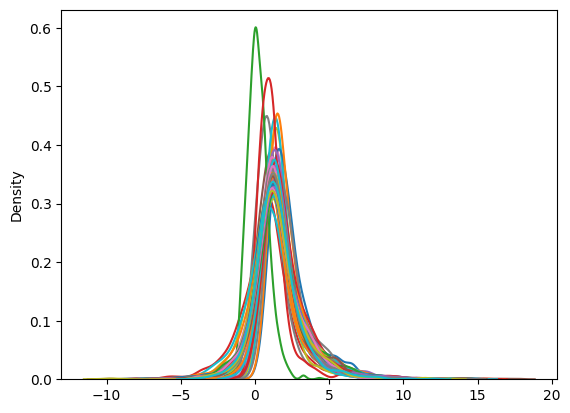

In [ ]:
for i in range(m.posteriors['betas_alpha_soc'].shape[1]):
    sns.kdeplot(m.posteriors['betas_alpha_soc'][:,i])


# Multiple networks


In [13]:
N=200 # Number of individuals
times=100 # number of time steps
m = bee(platform='cpu')
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

# Multinetworks -------------------------------------------------------------
tmp = covariates_data['network'][:, :, jnp.newaxis, jnp.newaxis]
time_varying_networks = jnp.broadcast_to(tmp, shape=(N, N, times, 2))
jnp.array_equal(time_varying_networks[:,:,0,0], covariates_data['network'])     


nbda=NBDA(time_varying_networks, jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.get_cov()
print(nbda.multi_network )
print(nbda.time_varying_network)
print(nbda.multiprocess)
print(nbda.T_asocial.shape, nbda.T_social.shape, nbda.network.shape)


jax.local_device_count 16
Simulated network with N =  200
True
True
False
(200, 100, 1) (200, 200, 100, 2) (200, 200, 100, 2)


In [147]:
def diffusion_multinetwork(data, alpha_social, alpha_asocial):
    D_social = data.T_social
    D_asocial = data.T_asocial
    informed = jnp.zeros((data.n,  data.t), dtype=int)
    N_network = data.network.shape[3]  # Number of networks

    # Asocial learning only at t = 0-----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], alpha_asocial, axes=(-1, 0))
    theta = m.link.inv_logit(R_asocial)

    # Informed update at t = 0-----------------------
    informed = informed.at[:,0].set(m.dist.binomial(total_count=jnp.ones(theta.shape[0], dtype=int), probs = theta, sample=True, seed = random2.randint(0,10000)))

    for t in range(1,data.t):      
        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], alpha_asocial, axes=(-1, 0))
        theta = m.link.inv_logit(R_asocial)

        social_influence = []
        for k in range(N_network):
            ## Social learning-----------------------
            R_social = jnp.tensordot(D_social[:,:,t,:], alpha_social[:,k], axes=(-1, 0))
            phi = m.link.inv_logit(R_social)   
            attention_weigthed_network = phi*data.network[:,:,t,k]
            social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], informed[:,t-1], axes=(-1, 0)))

            if k == 0:
                social_influence = social_influence_weight
            else: 
                social_influence = jnp.stack([social_influence, social_influence_weight], axis = 1)


        # Informed update at t!= 0-----------------------
        p = jnp.hstack([social_influence, theta[:, None] ])
        p = jnp.sum(p, axis=1)

        informed =  informed.at[:,t].set(
            jnp.where(
                informed[:, t-1] == 1, 1,
                m.dist.binomial(
                    total_count=jnp.asarray([1], dtype=jnp.int64),
                    probs = p, 
                    sample=True, 
                    seed = random2.randint(0,10000)
                )
            )
        )
        

    return informed

alpha_social = jnp.array([[1, -1 ],
                          [0.5, 1 ]])
alpha_asocial =jnp.array([-5])
status = diffusion_multinetwork(nbda, alpha_social, alpha_asocial)
nbda=NBDA(time_varying_networks, status) 
nbda.get_cov()


In [148]:
def model_multinetwork(nbda):
    status = nbda.status
    network = nbda.network
    T_social = nbda.T_social
    T_asocial = nbda.T_asocial
    N = status.shape[0] # Number of individuals
    T = status.shape[1] # Number of time steps
    P = status.shape[2] # Number of processes
    K = network.shape[3] # Number of networks
    lk = jnp.zeros((N,T, P))

    # Priors for social effect covariates
    alpha_soc = m.dist.normal(0, 5, shape = (1,K), sample=False, name='alpha_soc')
    betas_soc = m.dist.normal(0, 1, shape = (T_social.shape[3]-1,K), sample=False, name='betas_soc')
    soc = jnp.concatenate((alpha_soc, betas_soc))

    # Priors for asocial effect covariates
    alpha_asoc = m.dist.normal(0, 5,  shape = (1,), sample=False, name='alpha_asoc')
    betas_asoc = m.dist.normal(0, 1, shape = (T_asocial.shape[2]-1,), sample=False, name='betas_asoc')
    asoc = jnp.concatenate((alpha_asoc, betas_asoc))

    # Asocial learning -----------------------
    R_asocial = jnp.tensordot(T_asocial[:,0,:], asoc, axes=(-1, 0))    
    theta = m.link.inv_logit(R_asocial)
    lk = lk.at[:,0, 0].set(theta)

    for p in range(1,P): # for each process
        for t in range(1,T): # for each time step
            ## Asocial learning -----------------------
            R_asocial = jnp.tensordot(T_asocial[:,t,:], asoc, axes=(-1, 0))
            theta = m.link.inv_logit(R_asocial)

            social_influence = []
            for k in range(K): # for each network
                ## Social learning-----------------------
                R_social = jnp.tensordot(T_social[:,:,t,:], soc[:,k], axes=(-1, 0)) # dot product through [i,j] axis
                phi = m.link.inv_logit(R_social)
                attention_weigthed_network = phi*network[:,:,t,k]
                social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0))) # dot product through [i] axis
                if k == 0:
                    social_influence = social_influence_weight
                else: 
                    social_influence = jnp.stack([social_influence, social_influence_weight], axis = 1) # combinations of social influences probabilities 

            p = jnp.hstack([social_influence, theta[:, None] ])
            p = jnp.sum(p, axis=1)
            # Informed update at t!= 0-----------------------
            lk = lk.at[:,t, p].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, p))

        
    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status)

In [149]:

# Run model to recover parameters
m = bee()
m.data_on_model=dict(nbda = nbda)
m.run(model_multinetwork, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

# alpha_social = jnp.array([[1, -1 ],
#                          [0.5, 1 ]])
# alpha_asocial =jnp.array([-5])

jax.local_device_count 16


sample: 100%|██████████| 2000/2000 [00:16<00:00, 124.89it/s, 7 steps of size 6.72e-01. acc. prob=0.90]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated parameters
                 mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
alpha_asoc[0]   -5.47  1.00     -6.99      -3.95       0.03     0.03   
alpha_soc[0, 0]  0.15  5.10     -7.96       8.05       0.15     0.16   
alpha_soc[0, 1] -0.31  4.93     -8.53       6.93       0.14     0.17   
betas_soc[0, 0] -0.02  1.01     -1.50       1.79       0.03     0.03   
betas_soc[0, 1] -0.00  0.99     -1.57       1.53       0.03     0.03   

                 ess_bulk  ess_tail  r_hat  
alpha_asoc[0]      978.19    562.25    NaN  
alpha_soc[0, 0]   1214.79    807.14    NaN  
alpha_soc[0, 1]   1189.90    749.23    NaN  
betas_soc[0, 0]   1243.46    734.06    NaN  
betas_soc[0, 1]   1354.80    676.69    NaN  


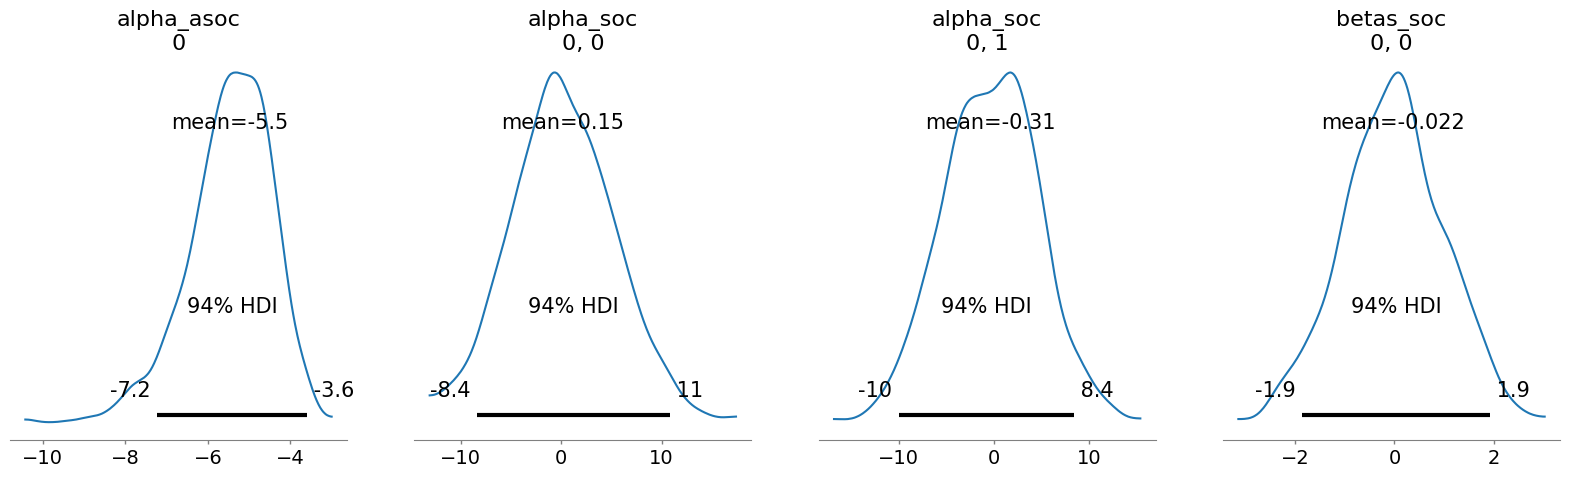

In [154]:
m.diag.posterior(figsize=(20,5))